# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz'
           }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)

Mounted at /content/gdrive


# PyTorch Dataset

Here you will implement a simple pytorch dataset that loads the images and labels as describe in the PDF.

In [0]:
# torch and torchvision imports
import torch
import torchvision
import numpy as np 


class HW2TrainDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    images = np.load('/content/images.npz')
    images = images["arr_0"]
    self.images_train = images[0:9000]
    

    labels = np.load('/content/labels.npz',allow_pickle = True, encoding = "latin1")
    labels = labels["arr_0"]
    self.labels_train = labels[0:9000]
  
  def convertLabel(self,labels):
    
    ground_truth = np.zeros((8,8,8))
    
    for label in labels:
      
      width = label[3] - label[1]
      height = label[4] - label[2]
      
      object_class = label[0]
      
      x_c = label[1] + width/2
      y_c = label[2] + height/2

      x_i = int((x_c/16))
      y_i = int((y_c/16))

      ground_truth[0][y_i][x_i] = 1
      ground_truth[1][y_i][x_i] = (x_c- (x_i * 16))/16
      ground_truth[2][y_i][x_i] = (y_c- (y_i * 16))/16
      ground_truth[3][y_i][x_i] = float(width/128)
      ground_truth[4][y_i][x_i] = float(height/128)
      ground_truth[5][y_i][x_i] = (object_class == 0)
      ground_truth[6][y_i][x_i] = (object_class == 1)
      ground_truth[7][y_i][x_i] = (object_class == 2)
    return ground_truth

    
  def __getitem__(self, index):
    
    image = self.images_train[index]
    image = image.transpose((2,0,1))
    image = torch.tensor(image).type(torch.FloatTensor)
    label = torch.tensor(self.convertLabel(self.labels_train[index]))
    
    return image,label
  
  def __len__(self):
    return len(self.images_train)
    

class HW2TestDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    images = np.load('/content/images.npz')
    images = images["arr_0"]
    self.images_test = images[9000:10000]

    labels = np.load('/content/labels.npz',allow_pickle = True, encoding = "latin1")
    labels = labels["arr_0"]
    self.labels_test = labels[9000:10000]
    
  def convertLabel(self,labels):
    ground_truth = np.zeros((8,8,8))
    for label in labels:
      width = label[3] - label[1]
      height = label[4] = label[2]
      object_class = label[0]
      x_c = label[1] + width/2
      y_c = label[2] + height/2

      x_i = int((x_c/16))
      y_i = int((y_c/16))
      ground_truth[0][y_i][x_i] = 1
      ground_truth[1][y_i][x_i] = (x_c - (x_i * 16))/16
      ground_truth[2][y_i][x_i] = (y_c - (y_i * 16))/16
      ground_truth[3][y_i][x_i] = float(width/128)
      ground_truth[4][y_i][x_i] = float(height/128)
      ground_truth[5][y_i][x_i] = (object_class == 0)
      ground_truth[6][y_i][x_i] = (object_class == 1)
      ground_truth[7][y_i][x_i] = (object_class == 2)
      
    return ground_truth
  
    
  def __len__(self):
    return len(self.images_test)
  

    
  def __getitem__(self, index):
    image = self.images_test[index]
#     print(image.transpose((2, 0, 1).shape))
    image = torch.tensor(image.transpose((2, 0, 1))).type(torch.FloatTensor)
    label = torch.tensor(self.convertLabel(self.labels_test[index]))
    
    return image,label
 


# Dataset test

The data set class can be tested here. 


In [4]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

train_dataset = HW2TrainDataset(None)
image,label = train_dataset.__getitem__(15)
print(image.shape)
image = image.type(torch.IntTensor).numpy()
image = np.transpose(image,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(image)

label = label.numpy()

for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.5:
      if label[5][i][j]>0.5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0.5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0.5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
        
plt.show()

KeyboardInterrupt: ignored

# Model Definition

In [0]:
import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.nn.functional as F 


class YOLOish(torch.nn.Module):
  def __init__(self):
    super(YOLOish,self).__init__()
    self.cn1 = nn.Conv2d(3,32,kernel_size = 4,stride = 2, padding = 1)
    self.cn1_bn = nn.BatchNorm2d(32)
    self.cn2 = nn.Conv2d(32,64,kernel_size = 4,stride = 2, padding = 1)
    self.cn2_bn = nn.BatchNorm2d(64)
    self.cn3 = nn.Conv2d(64,128,kernel_size = 4,stride = 2, padding = 1)
    self.cn3_bn = nn.BatchNorm2d(128)
    self.cn4 = nn.Conv2d(128,256,kernel_size = 4,stride = 2, padding = 1)
    self.cn4_bn = nn.BatchNorm2d(256)
    self.cn5 = nn.Conv2d(256,512,kernel_size = 4,stride = 2, padding = 1)
    self.cn5_bn = nn.BatchNorm2d(512)
    self.cn6 = nn.Conv2d(512,1024,kernel_size = 4,stride = 2, padding = 1)
    self.cn6_bn = nn.BatchNorm2d(1024)
    self.cn7 = nn.ConvTranspose2d(1024,256,kernel_size = 4,stride = 2, padding = 1)
    self.cn7_bn = nn.BatchNorm2d(256)
    self.cn8 = nn.ConvTranspose2d(256,64,kernel_size = 4,stride = 2, padding = 1)
    self.cn8_bn = nn.BatchNorm2d(64)
    self.cn9 = nn.Conv2d(64,8,kernel_size = 3,stride = 1, padding = 1)
    

    
  def forward(self, X):
    x = self.cn1(X)
    x = F.relu(self.cn1_bn(x))
    x = self.cn2(x)
    x = F.relu(self.cn2_bn(x))
    x = self.cn3(x)
    x = F.relu(self.cn3_bn(x))
    x = self.cn4(x)
    x = F.relu(self.cn4_bn(x))
    x = self.cn5(x)
    x = F.relu(self.cn5_bn(x))
    x = self.cn6(x)
    x = F.relu(self.cn6_bn(x))
    x = self.cn7(x)
    x = F.relu(self.cn7_bn(x))
    x = self.cn8(x)
    x = F.relu(self.cn8_bn(x))
    x = self.cn9(x)
    x = F.sigmoid(x)
    return x

# Train your network

Training the network

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/9000 (0%)]	Loss: 362.420680
train map is : 0.0
Train Epoch: 0 [160/9000 (2%)]	Loss: 168.746487
train map is : 0.0
Train Epoch: 0 [320/9000 (4%)]	Loss: 129.361950
train map is : 0.0
Train Epoch: 0 [480/9000 (5%)]	Loss: 148.571113
train map is : 0.03225806451612903
Train Epoch: 0 [640/9000 (7%)]	Loss: 117.047555
train map is : 0.024390243902439025
Train Epoch: 0 [800/9000 (9%)]	Loss: 104.919109
train map is : 0.058823529411764705
Train Epoch: 0 [960/9000 (11%)]	Loss: 122.214695
train map is : 0.04918032786885246
Train Epoch: 0 [1120/9000 (12%)]	Loss: 112.774309
train map is : 0.056338028169014086
Train Epoch: 0 [1280/9000 (14%)]	Loss: 144.825751
train map is : 0.06172839506172839
Train Epoch: 0 [1440/9000 (16%)]	Loss: 156.536558
train map is : 0.054945054945054944
Train Epoch: 0 [1600/9000 (18%)]	Loss: 132.476082
train map is : 0.04950495049504951
Train Epoch: 0 [1760/9000 (20%)]	Loss: 131.350000
train map is : 0.06306306306306306
Train Epoch: 0 [1920/9000 (21%)]	Loss: 

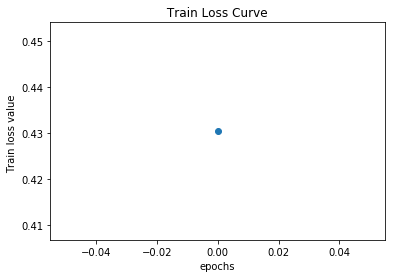

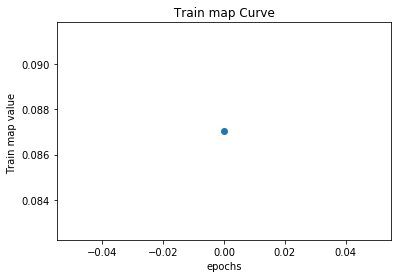

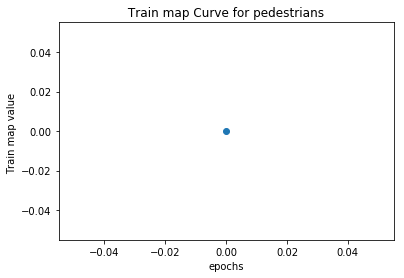

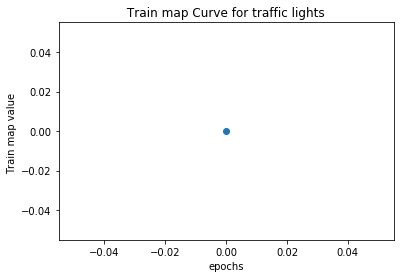

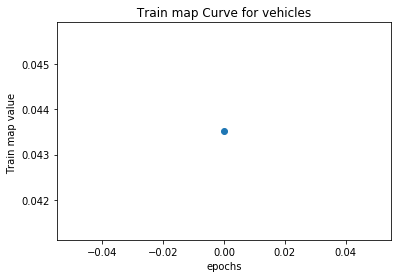

Epoch 1/50
Train Epoch: 1 [0/9000 (0%)]	Loss: 84.431848
train map is : 0.0
Train Epoch: 1 [160/9000 (2%)]	Loss: 89.186174
train map is : 0.0
Train Epoch: 1 [320/9000 (4%)]	Loss: 94.369728
train map is : 0.047619047619047616
Train Epoch: 1 [480/9000 (5%)]	Loss: 96.653892
train map is : 0.06451612903225806
Train Epoch: 1 [640/9000 (7%)]	Loss: 95.649272
train map is : 0.0975609756097561
Train Epoch: 1 [800/9000 (9%)]	Loss: 113.327869
train map is : 0.11764705882352941
Train Epoch: 1 [960/9000 (11%)]	Loss: 80.004255
train map is : 0.13114754098360656
Train Epoch: 1 [1120/9000 (12%)]	Loss: 92.316902
train map is : 0.1267605633802817
Train Epoch: 1 [1280/9000 (14%)]	Loss: 131.818688
train map is : 0.1111111111111111
Train Epoch: 1 [1440/9000 (16%)]	Loss: 95.105651
train map is : 0.10989010989010989
Train Epoch: 1 [1600/9000 (18%)]	Loss: 89.034176
train map is : 0.10891089108910891
Train Epoch: 1 [1760/9000 (20%)]	Loss: 84.222292
train map is : 0.10810810810810811
Train Epoch: 1 [1920/9000 (2

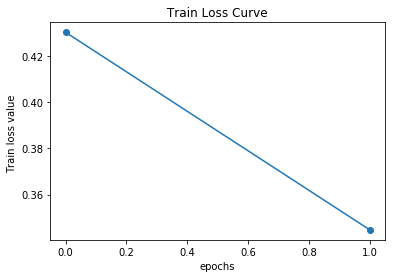

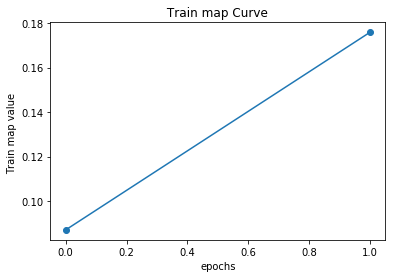

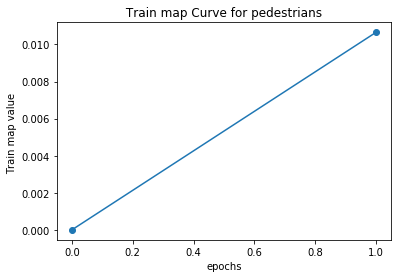

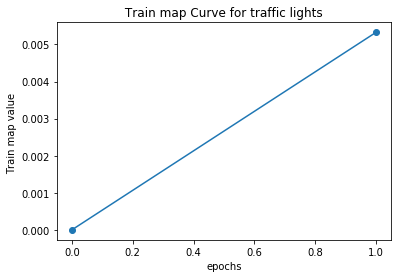

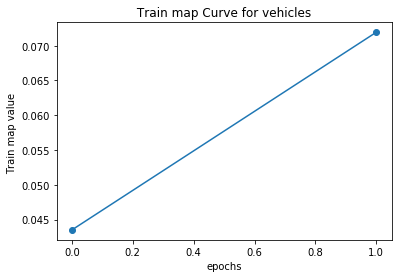

Epoch 2/50
Train Epoch: 2 [0/9000 (0%)]	Loss: 59.562683
train map is : 0.0
Train Epoch: 2 [160/9000 (2%)]	Loss: 91.374817
train map is : 0.2727272727272727
Train Epoch: 2 [320/9000 (4%)]	Loss: 81.275051
train map is : 0.2857142857142857
Train Epoch: 2 [480/9000 (5%)]	Loss: 86.292124
train map is : 0.25806451612903225
Train Epoch: 2 [640/9000 (7%)]	Loss: 78.988613
train map is : 0.2926829268292683
Train Epoch: 2 [800/9000 (9%)]	Loss: 78.204095
train map is : 0.23529411764705882
Train Epoch: 2 [960/9000 (11%)]	Loss: 79.363025
train map is : 0.22950819672131148
Train Epoch: 2 [1120/9000 (12%)]	Loss: 69.578532
train map is : 0.2535211267605634
Train Epoch: 2 [1280/9000 (14%)]	Loss: 87.206051
train map is : 0.24691358024691357
Train Epoch: 2 [1440/9000 (16%)]	Loss: 72.909063
train map is : 0.23076923076923078
Train Epoch: 2 [1600/9000 (18%)]	Loss: 80.307092
train map is : 0.2376237623762376
Train Epoch: 2 [1760/9000 (20%)]	Loss: 95.568485
train map is : 0.21621621621621623
Train Epoch: 2 [1

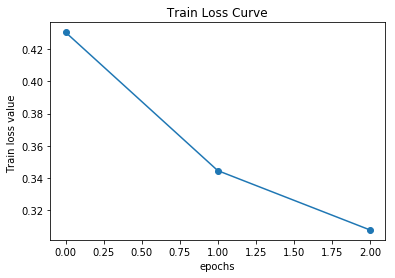

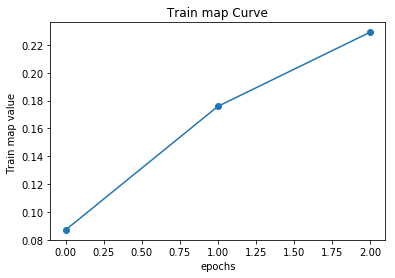

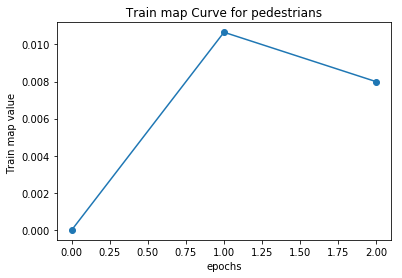

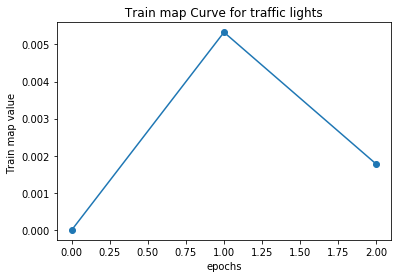

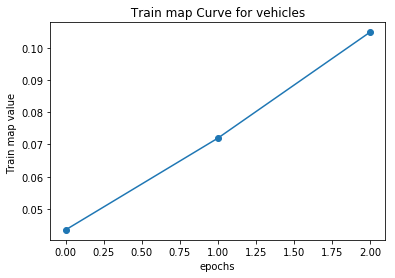

Epoch 3/50
Train Epoch: 3 [0/9000 (0%)]	Loss: 66.389279
train map is : 0.0
Train Epoch: 3 [160/9000 (2%)]	Loss: 78.262008
train map is : 0.18181818181818182
Train Epoch: 3 [320/9000 (4%)]	Loss: 62.097018
train map is : 0.23809523809523808
Train Epoch: 3 [480/9000 (5%)]	Loss: 72.818783
train map is : 0.22580645161290322
Train Epoch: 3 [640/9000 (7%)]	Loss: 66.778105
train map is : 0.24390243902439024
Train Epoch: 3 [800/9000 (9%)]	Loss: 87.178501
train map is : 0.19607843137254902
Train Epoch: 3 [960/9000 (11%)]	Loss: 88.276304
train map is : 0.16393442622950818
Train Epoch: 3 [1120/9000 (12%)]	Loss: 71.114132
train map is : 0.19718309859154928
Train Epoch: 3 [1280/9000 (14%)]	Loss: 78.233939
train map is : 0.19753086419753085
Train Epoch: 3 [1440/9000 (16%)]	Loss: 68.947874
train map is : 0.21978021978021978
Train Epoch: 3 [1600/9000 (18%)]	Loss: 78.824450
train map is : 0.21782178217821782
Train Epoch: 3 [1760/9000 (20%)]	Loss: 70.646876
train map is : 0.23423423423423423
Train Epoch:

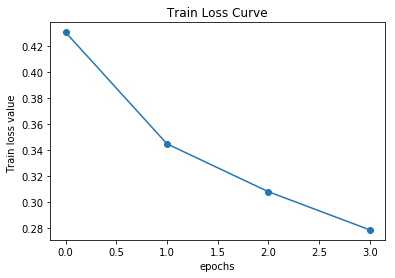

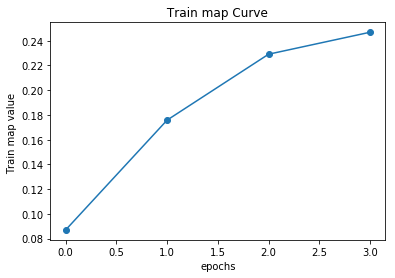

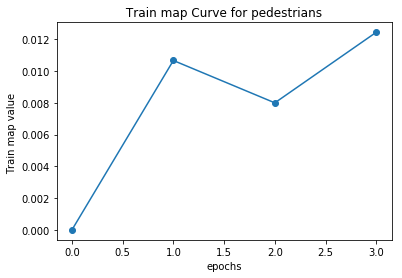

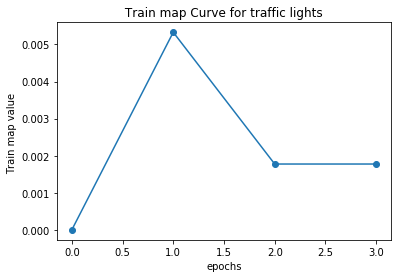

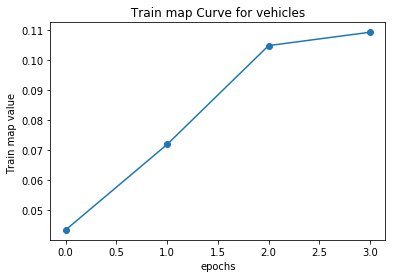

Epoch 4/50
Train Epoch: 4 [0/9000 (0%)]	Loss: 60.324877
train map is : 0.0
Train Epoch: 4 [160/9000 (2%)]	Loss: 78.645217
train map is : 0.09090909090909091
Train Epoch: 4 [320/9000 (4%)]	Loss: 71.757508
train map is : 0.09523809523809523
Train Epoch: 4 [480/9000 (5%)]	Loss: 68.649919
train map is : 0.16129032258064516
Train Epoch: 4 [640/9000 (7%)]	Loss: 73.918696
train map is : 0.14634146341463414
Train Epoch: 4 [800/9000 (9%)]	Loss: 68.629217
train map is : 0.1568627450980392
Train Epoch: 4 [960/9000 (11%)]	Loss: 74.324016
train map is : 0.19672131147540983
Train Epoch: 4 [1120/9000 (12%)]	Loss: 48.783383
train map is : 0.2112676056338028
Train Epoch: 4 [1280/9000 (14%)]	Loss: 74.593400
train map is : 0.19753086419753085
Train Epoch: 4 [1440/9000 (16%)]	Loss: 61.478047
train map is : 0.18681318681318682
Train Epoch: 4 [1600/9000 (18%)]	Loss: 56.373987
train map is : 0.19801980198019803
Train Epoch: 4 [1760/9000 (20%)]	Loss: 66.391685
train map is : 0.1981981981981982
Train Epoch: 4 

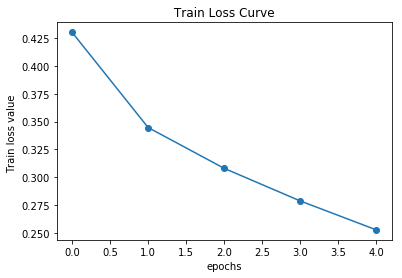

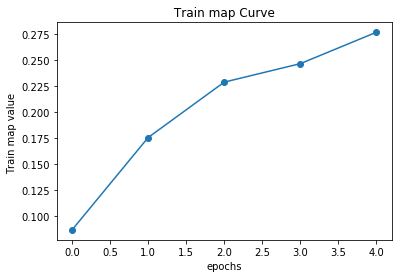

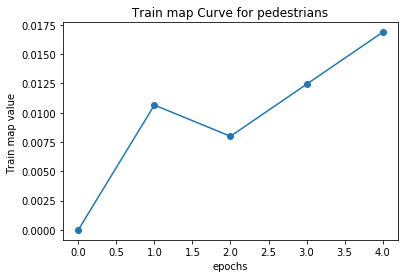

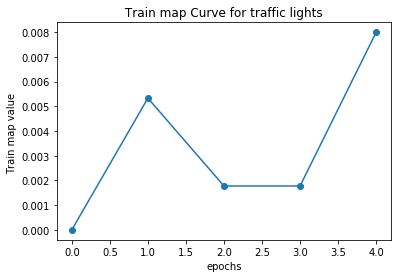

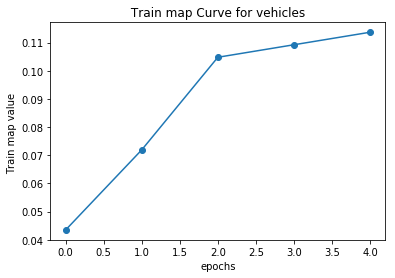

Epoch 5/50
Train Epoch: 5 [0/9000 (0%)]	Loss: 57.041475
train map is : 1.0
Train Epoch: 5 [160/9000 (2%)]	Loss: 66.679269
train map is : 0.18181818181818182
Train Epoch: 5 [320/9000 (4%)]	Loss: 48.182566
train map is : 0.23809523809523808
Train Epoch: 5 [480/9000 (5%)]	Loss: 52.385558
train map is : 0.25806451612903225
Train Epoch: 5 [640/9000 (7%)]	Loss: 58.446321
train map is : 0.2926829268292683
Train Epoch: 5 [800/9000 (9%)]	Loss: 65.756852
train map is : 0.29411764705882354
Train Epoch: 5 [960/9000 (11%)]	Loss: 55.884068
train map is : 0.32786885245901637
Train Epoch: 5 [1120/9000 (12%)]	Loss: 62.787715
train map is : 0.352112676056338
Train Epoch: 5 [1280/9000 (14%)]	Loss: 63.486751
train map is : 0.35802469135802467
Train Epoch: 5 [1440/9000 (16%)]	Loss: 67.580918
train map is : 0.32967032967032966
Train Epoch: 5 [1600/9000 (18%)]	Loss: 52.793993
train map is : 0.32673267326732675
Train Epoch: 5 [1760/9000 (20%)]	Loss: 70.971316
train map is : 0.3153153153153153
Train Epoch: 5 [

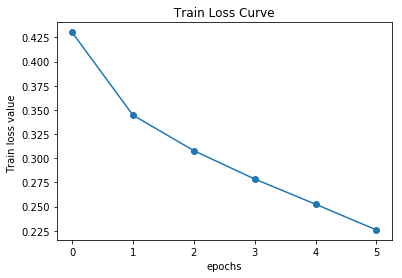

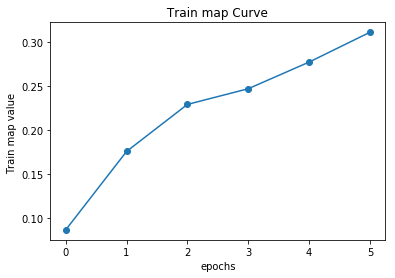

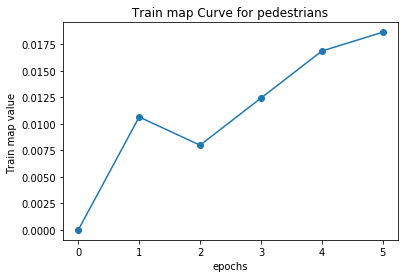

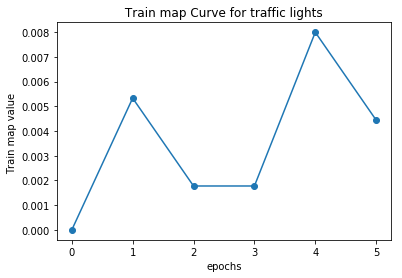

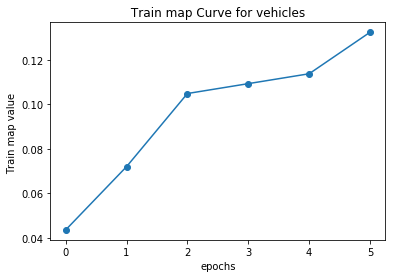

Epoch 6/50
Train Epoch: 6 [0/9000 (0%)]	Loss: 50.580335
train map is : 1.0
Train Epoch: 6 [160/9000 (2%)]	Loss: 41.065434
train map is : 0.5454545454545454
Train Epoch: 6 [320/9000 (4%)]	Loss: 48.055589
train map is : 0.38095238095238093
Train Epoch: 6 [480/9000 (5%)]	Loss: 73.243940
train map is : 0.3870967741935484
Train Epoch: 6 [640/9000 (7%)]	Loss: 46.740192
train map is : 0.3170731707317073
Train Epoch: 6 [800/9000 (9%)]	Loss: 47.889143
train map is : 0.35294117647058826
Train Epoch: 6 [960/9000 (11%)]	Loss: 44.845592
train map is : 0.3442622950819672
Train Epoch: 6 [1120/9000 (12%)]	Loss: 54.666182
train map is : 0.3380281690140845
Train Epoch: 6 [1280/9000 (14%)]	Loss: 47.560934
train map is : 0.38271604938271603
Train Epoch: 6 [1440/9000 (16%)]	Loss: 36.383320
train map is : 0.38461538461538464
Train Epoch: 6 [1600/9000 (18%)]	Loss: 66.783060
train map is : 0.40594059405940597
Train Epoch: 6 [1760/9000 (20%)]	Loss: 47.112232
train map is : 0.3963963963963964
Train Epoch: 6 [19

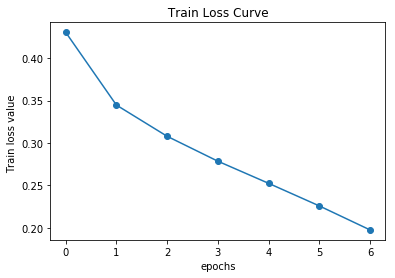

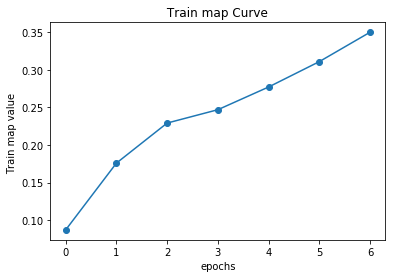

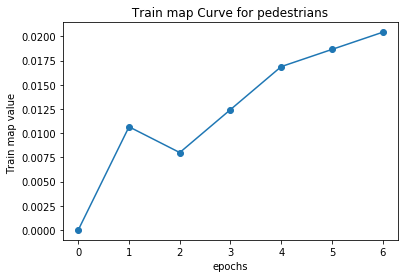

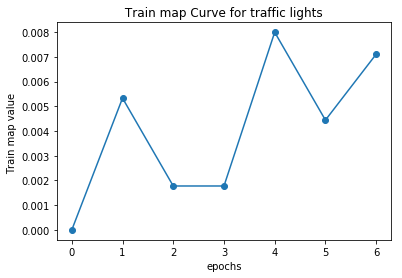

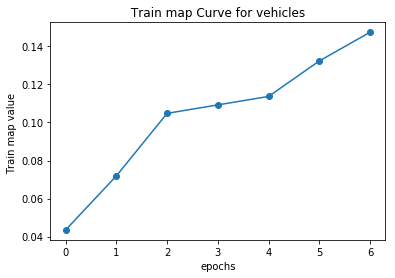

Epoch 7/50
Train Epoch: 7 [0/9000 (0%)]	Loss: 56.886186
train map is : 1.0
Train Epoch: 7 [160/9000 (2%)]	Loss: 44.320576
train map is : 0.36363636363636365
Train Epoch: 7 [320/9000 (4%)]	Loss: 35.254504
train map is : 0.2857142857142857
Train Epoch: 7 [480/9000 (5%)]	Loss: 48.009987
train map is : 0.3870967741935484
Train Epoch: 7 [640/9000 (7%)]	Loss: 43.817343
train map is : 0.34146341463414637
Train Epoch: 7 [800/9000 (9%)]	Loss: 56.693543
train map is : 0.37254901960784315
Train Epoch: 7 [960/9000 (11%)]	Loss: 38.699990
train map is : 0.3770491803278688
Train Epoch: 7 [1120/9000 (12%)]	Loss: 45.428241
train map is : 0.36619718309859156
Train Epoch: 7 [1280/9000 (14%)]	Loss: 41.493334
train map is : 0.35802469135802467
Train Epoch: 7 [1440/9000 (16%)]	Loss: 32.506696
train map is : 0.34065934065934067
Train Epoch: 7 [1600/9000 (18%)]	Loss: 64.825380
train map is : 0.3564356435643564
Train Epoch: 7 [1760/9000 (20%)]	Loss: 30.794366
train map is : 0.36036036036036034
Train Epoch: 7 [

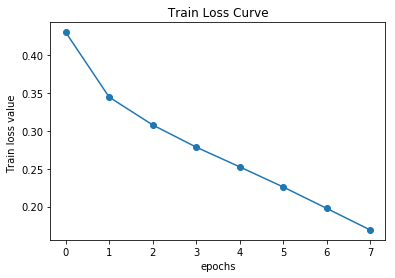

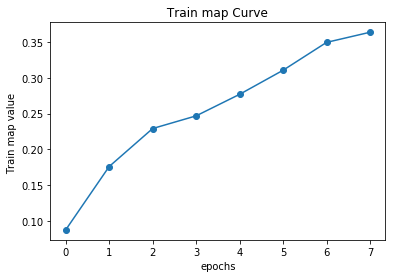

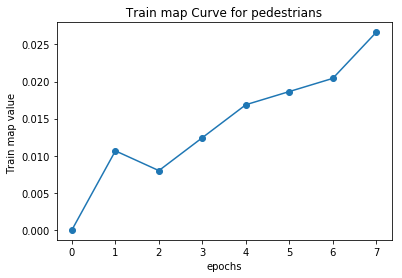

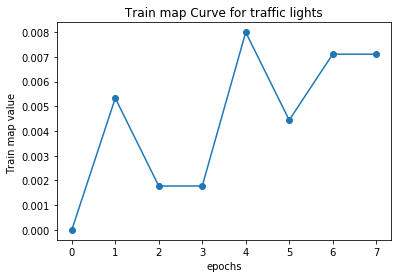

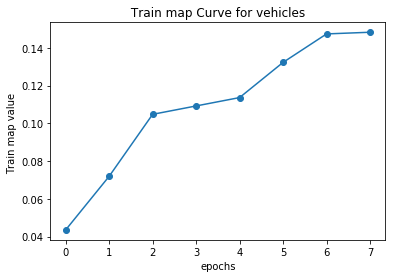

Epoch 8/50
Train Epoch: 8 [0/9000 (0%)]	Loss: 37.911023
train map is : 1.0
Train Epoch: 8 [160/9000 (2%)]	Loss: 36.301419
train map is : 0.45454545454545453
Train Epoch: 8 [320/9000 (4%)]	Loss: 38.881710
train map is : 0.3333333333333333
Train Epoch: 8 [480/9000 (5%)]	Loss: 37.993644
train map is : 0.3548387096774194
Train Epoch: 8 [640/9000 (7%)]	Loss: 32.579546
train map is : 0.34146341463414637
Train Epoch: 8 [800/9000 (9%)]	Loss: 37.330688
train map is : 0.39215686274509803
Train Epoch: 8 [960/9000 (11%)]	Loss: 53.725764
train map is : 0.4262295081967213
Train Epoch: 8 [1120/9000 (12%)]	Loss: 40.179557
train map is : 0.4507042253521127
Train Epoch: 8 [1280/9000 (14%)]	Loss: 34.640442
train map is : 0.4691358024691358
Train Epoch: 8 [1440/9000 (16%)]	Loss: 33.716644
train map is : 0.4945054945054945
Train Epoch: 8 [1600/9000 (18%)]	Loss: 40.128847
train map is : 0.4752475247524752
Train Epoch: 8 [1760/9000 (20%)]	Loss: 33.848603
train map is : 0.4594594594594595
Train Epoch: 8 [1920

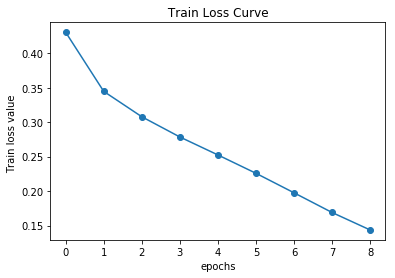

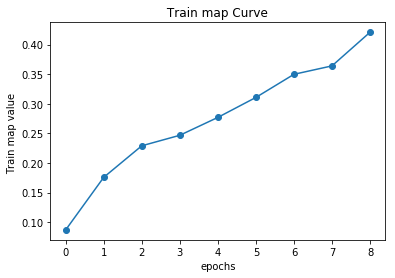

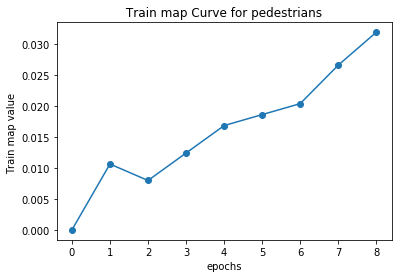

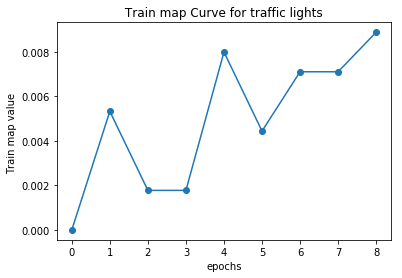

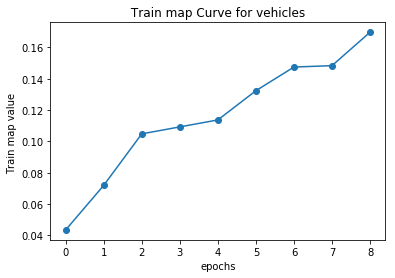

Epoch 9/50
Train Epoch: 9 [0/9000 (0%)]	Loss: 29.202063
train map is : 1.0
Train Epoch: 9 [160/9000 (2%)]	Loss: 28.055231
train map is : 0.5454545454545454
Train Epoch: 9 [320/9000 (4%)]	Loss: 30.700205
train map is : 0.47619047619047616
Train Epoch: 9 [480/9000 (5%)]	Loss: 34.135226
train map is : 0.5806451612903226
Train Epoch: 9 [640/9000 (7%)]	Loss: 24.971965
train map is : 0.5609756097560976
Train Epoch: 9 [800/9000 (9%)]	Loss: 26.096711
train map is : 0.5294117647058824
Train Epoch: 9 [960/9000 (11%)]	Loss: 26.868571
train map is : 0.5081967213114754
Train Epoch: 9 [1120/9000 (12%)]	Loss: 32.956084
train map is : 0.4788732394366197
Train Epoch: 9 [1280/9000 (14%)]	Loss: 30.367006
train map is : 0.4691358024691358
Train Epoch: 9 [1440/9000 (16%)]	Loss: 28.417336
train map is : 0.46153846153846156
Train Epoch: 9 [1600/9000 (18%)]	Loss: 29.963192
train map is : 0.45544554455445546
Train Epoch: 9 [1760/9000 (20%)]	Loss: 24.478585
train map is : 0.4864864864864865
Train Epoch: 9 [1920

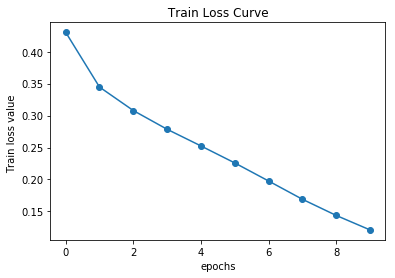

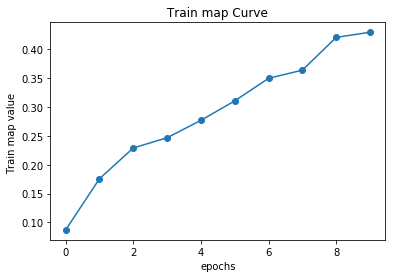

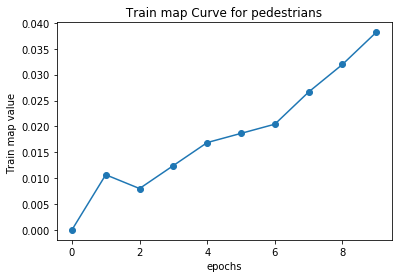

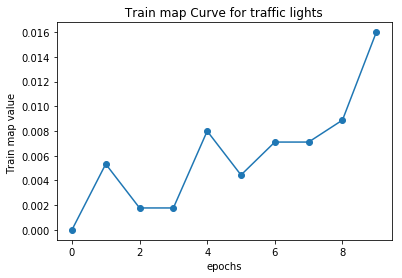

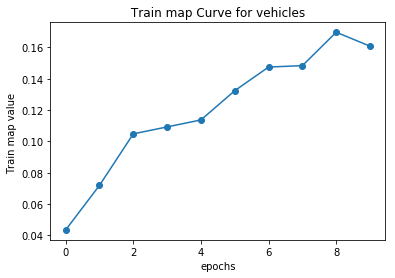

Epoch 10/50
Train Epoch: 10 [0/9000 (0%)]	Loss: 25.720296
train map is : 0.0
Train Epoch: 10 [160/9000 (2%)]	Loss: 25.272637
train map is : 0.36363636363636365
Train Epoch: 10 [320/9000 (4%)]	Loss: 28.671229
train map is : 0.3333333333333333
Train Epoch: 10 [480/9000 (5%)]	Loss: 29.277465
train map is : 0.41935483870967744
Train Epoch: 10 [640/9000 (7%)]	Loss: 21.045478
train map is : 0.36585365853658536
Train Epoch: 10 [800/9000 (9%)]	Loss: 29.622176
train map is : 0.4117647058823529
Train Epoch: 10 [960/9000 (11%)]	Loss: 27.876916
train map is : 0.39344262295081966
Train Epoch: 10 [1120/9000 (12%)]	Loss: 20.933548
train map is : 0.38028169014084506
Train Epoch: 10 [1280/9000 (14%)]	Loss: 19.206323
train map is : 0.4074074074074074
Train Epoch: 10 [1440/9000 (16%)]	Loss: 26.512148
train map is : 0.4175824175824176
Train Epoch: 10 [1600/9000 (18%)]	Loss: 22.251814
train map is : 0.4158415841584158
Train Epoch: 10 [1760/9000 (20%)]	Loss: 24.255904
train map is : 0.40540540540540543
Trai

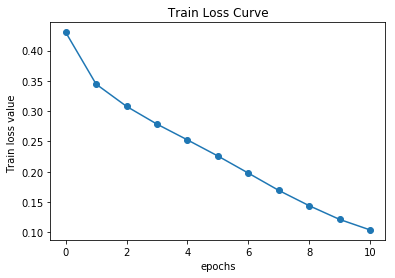

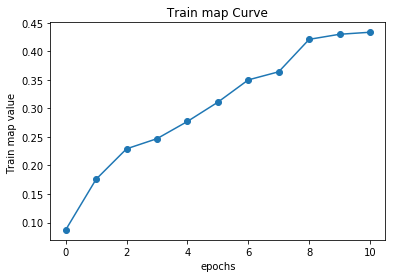

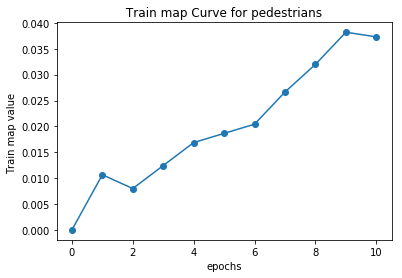

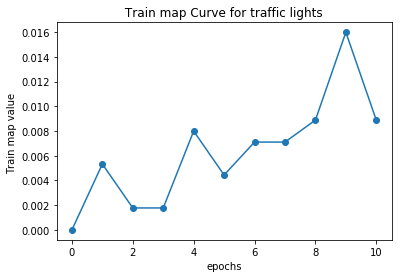

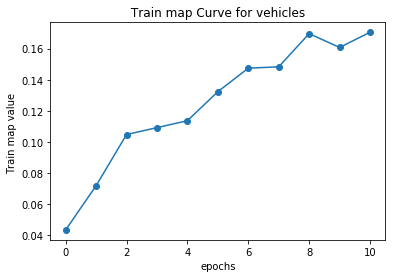

Epoch 11/50
Train Epoch: 11 [0/9000 (0%)]	Loss: 25.204238
train map is : 1.0
Train Epoch: 11 [160/9000 (2%)]	Loss: 21.041528
train map is : 0.45454545454545453
Train Epoch: 11 [320/9000 (4%)]	Loss: 19.939398
train map is : 0.42857142857142855
Train Epoch: 11 [480/9000 (5%)]	Loss: 36.073013
train map is : 0.5161290322580645
Train Epoch: 11 [640/9000 (7%)]	Loss: 27.455938
train map is : 0.5853658536585366
Train Epoch: 11 [800/9000 (9%)]	Loss: 16.596783
train map is : 0.5490196078431373
Train Epoch: 11 [960/9000 (11%)]	Loss: 19.485812
train map is : 0.5409836065573771
Train Epoch: 11 [1120/9000 (12%)]	Loss: 28.158118
train map is : 0.5352112676056338
Train Epoch: 11 [1280/9000 (14%)]	Loss: 14.062698
train map is : 0.5185185185185185
Train Epoch: 11 [1440/9000 (16%)]	Loss: 24.808452
train map is : 0.5164835164835165
Train Epoch: 11 [1600/9000 (18%)]	Loss: 19.853337
train map is : 0.5445544554455446
Train Epoch: 11 [1760/9000 (20%)]	Loss: 27.673703
train map is : 0.5585585585585585
Train Ep

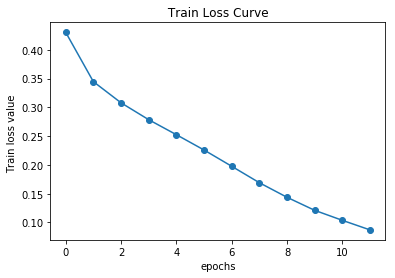

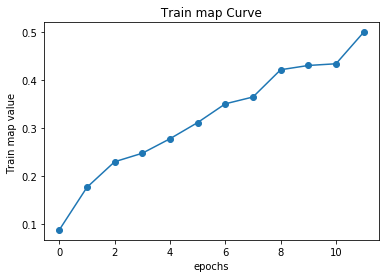

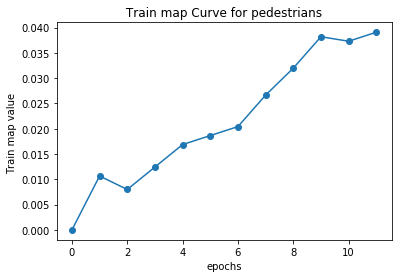

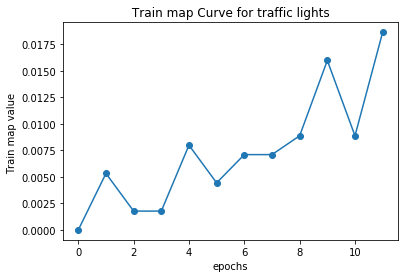

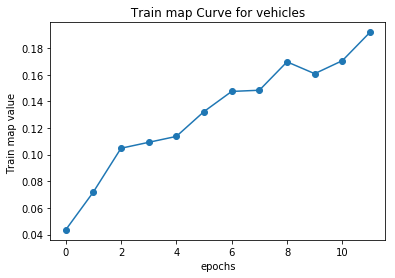

Epoch 12/50
Train Epoch: 12 [0/9000 (0%)]	Loss: 20.221963
train map is : 1.0
Train Epoch: 12 [160/9000 (2%)]	Loss: 19.249801
train map is : 0.45454545454545453
Train Epoch: 12 [320/9000 (4%)]	Loss: 16.032195
train map is : 0.47619047619047616
Train Epoch: 12 [480/9000 (5%)]	Loss: 13.873669
train map is : 0.5483870967741935
Train Epoch: 12 [640/9000 (7%)]	Loss: 21.941996
train map is : 0.5853658536585366
Train Epoch: 12 [800/9000 (9%)]	Loss: 20.402218
train map is : 0.5882352941176471
Train Epoch: 12 [960/9000 (11%)]	Loss: 14.965551
train map is : 0.5573770491803278
Train Epoch: 12 [1120/9000 (12%)]	Loss: 18.518471
train map is : 0.5774647887323944
Train Epoch: 12 [1280/9000 (14%)]	Loss: 17.660421
train map is : 0.5802469135802469
Train Epoch: 12 [1440/9000 (16%)]	Loss: 9.574522
train map is : 0.5604395604395604
Train Epoch: 12 [1600/9000 (18%)]	Loss: 18.031922
train map is : 0.5742574257425742
Train Epoch: 12 [1760/9000 (20%)]	Loss: 17.447714
train map is : 0.5855855855855856
Train Epo

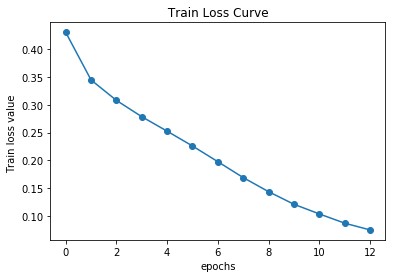

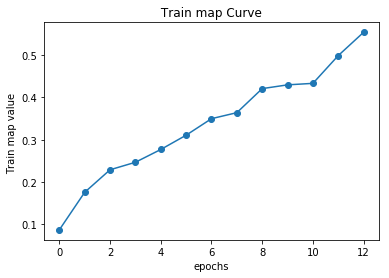

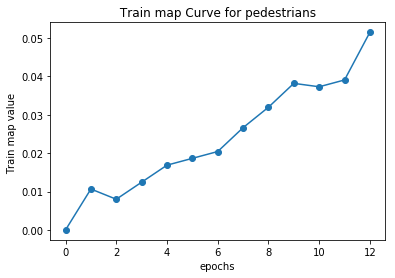

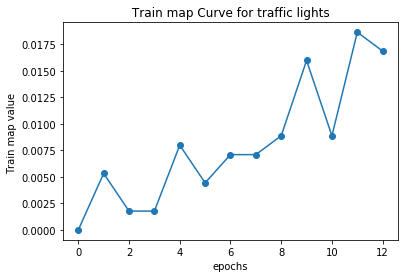

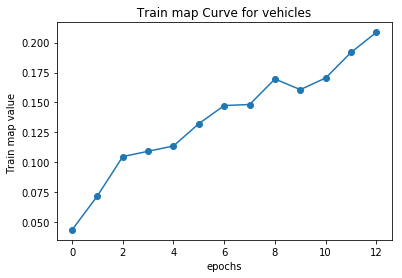

Epoch 13/50
Train Epoch: 13 [0/9000 (0%)]	Loss: 13.971209
train map is : 1.0
Train Epoch: 13 [160/9000 (2%)]	Loss: 20.954015
train map is : 0.45454545454545453
Train Epoch: 13 [320/9000 (4%)]	Loss: 18.648946
train map is : 0.5238095238095238
Train Epoch: 13 [480/9000 (5%)]	Loss: 18.315811
train map is : 0.4838709677419355
Train Epoch: 13 [640/9000 (7%)]	Loss: 16.333262
train map is : 0.5609756097560976
Train Epoch: 13 [800/9000 (9%)]	Loss: 18.125758
train map is : 0.5882352941176471
Train Epoch: 13 [960/9000 (11%)]	Loss: 13.705780
train map is : 0.6065573770491803
Train Epoch: 13 [1120/9000 (12%)]	Loss: 13.658475
train map is : 0.5915492957746479
Train Epoch: 13 [1280/9000 (14%)]	Loss: 16.844921
train map is : 0.5925925925925926
Train Epoch: 13 [1440/9000 (16%)]	Loss: 11.774454
train map is : 0.5714285714285714
Train Epoch: 13 [1600/9000 (18%)]	Loss: 15.380295
train map is : 0.5742574257425742
Train Epoch: 13 [1760/9000 (20%)]	Loss: 16.452605
train map is : 0.5585585585585585
Train Epo

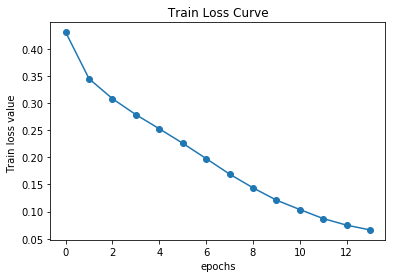

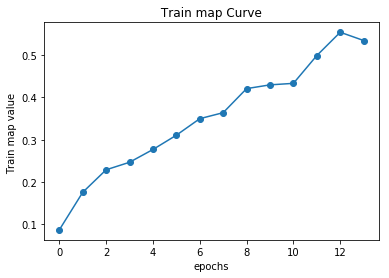

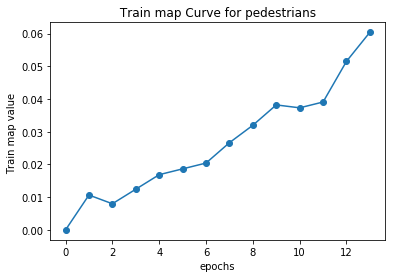

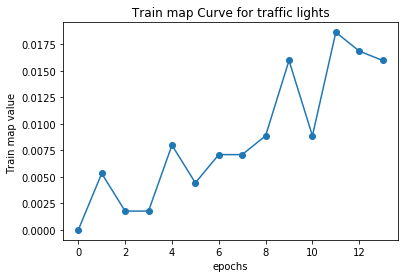

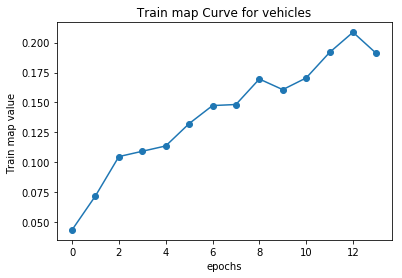

Epoch 14/50
Train Epoch: 14 [0/9000 (0%)]	Loss: 16.910535
train map is : 1.0
Train Epoch: 14 [160/9000 (2%)]	Loss: 10.213639
train map is : 0.5454545454545454
Train Epoch: 14 [320/9000 (4%)]	Loss: 13.378391
train map is : 0.5714285714285714
Train Epoch: 14 [480/9000 (5%)]	Loss: 14.556889
train map is : 0.6774193548387096
Train Epoch: 14 [640/9000 (7%)]	Loss: 17.435725
train map is : 0.6829268292682927
Train Epoch: 14 [800/9000 (9%)]	Loss: 11.206931
train map is : 0.6666666666666666
Train Epoch: 14 [960/9000 (11%)]	Loss: 23.202657
train map is : 0.639344262295082
Train Epoch: 14 [1120/9000 (12%)]	Loss: 12.406668
train map is : 0.6619718309859155
Train Epoch: 14 [1280/9000 (14%)]	Loss: 12.348860
train map is : 0.6172839506172839
Train Epoch: 14 [1440/9000 (16%)]	Loss: 12.712543
train map is : 0.6043956043956044
Train Epoch: 14 [1600/9000 (18%)]	Loss: 14.188651
train map is : 0.6039603960396039
Train Epoch: 14 [1760/9000 (20%)]	Loss: 13.449691
train map is : 0.6036036036036037
Train Epoch

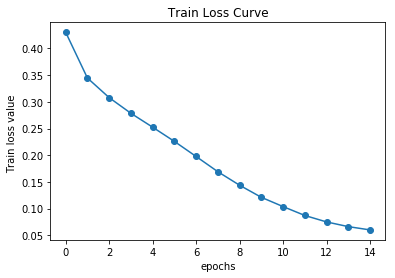

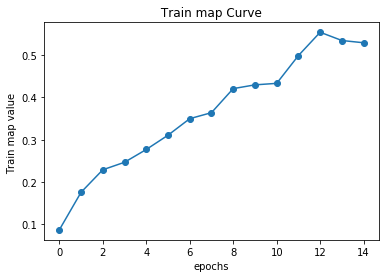

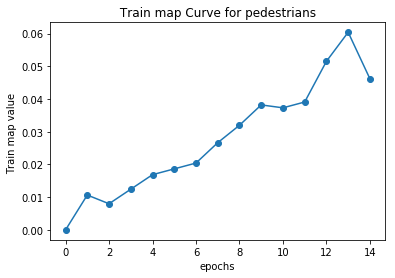

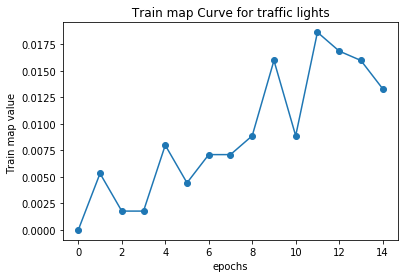

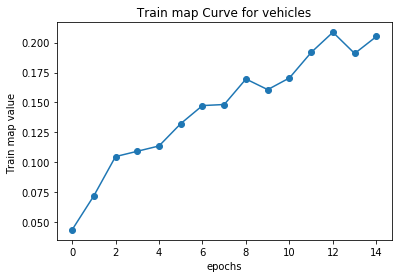

Epoch 15/50
Train Epoch: 15 [0/9000 (0%)]	Loss: 13.501413
train map is : 1.0
Train Epoch: 15 [160/9000 (2%)]	Loss: 16.550109
train map is : 0.8181818181818182
Train Epoch: 15 [320/9000 (4%)]	Loss: 11.558092
train map is : 0.7142857142857143
Train Epoch: 15 [480/9000 (5%)]	Loss: 11.566378
train map is : 0.7096774193548387
Train Epoch: 15 [640/9000 (7%)]	Loss: 15.782222
train map is : 0.7317073170731707
Train Epoch: 15 [800/9000 (9%)]	Loss: 15.212195
train map is : 0.7254901960784313
Train Epoch: 15 [960/9000 (11%)]	Loss: 17.883419
train map is : 0.6721311475409836
Train Epoch: 15 [1120/9000 (12%)]	Loss: 8.807936
train map is : 0.676056338028169
Train Epoch: 15 [1280/9000 (14%)]	Loss: 6.703536
train map is : 0.6790123456790124
Train Epoch: 15 [1440/9000 (16%)]	Loss: 13.871284
train map is : 0.6703296703296703
Train Epoch: 15 [1600/9000 (18%)]	Loss: 12.163112
train map is : 0.6435643564356436
Train Epoch: 15 [1760/9000 (20%)]	Loss: 16.622307
train map is : 0.6396396396396397
Train Epoch: 

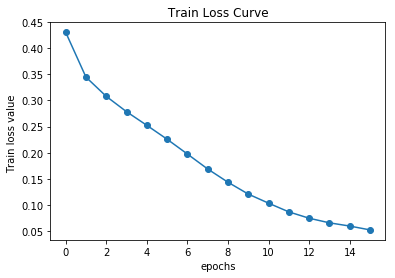

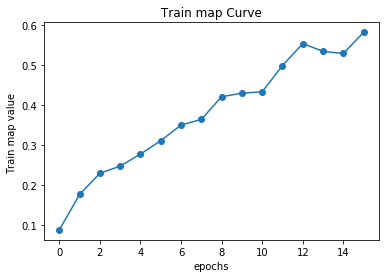

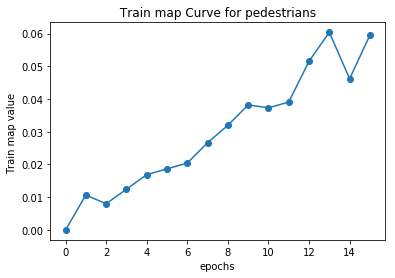

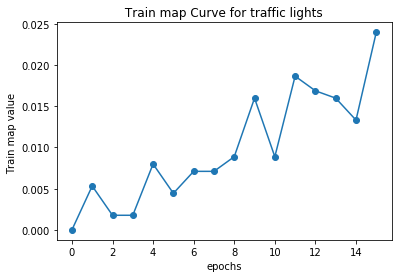

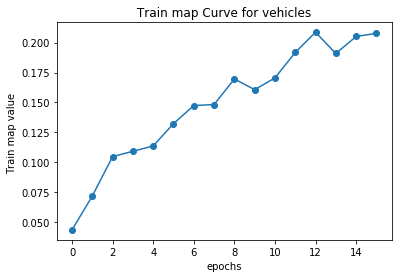

Epoch 16/50
Train Epoch: 16 [0/9000 (0%)]	Loss: 7.279654
train map is : 1.0
Train Epoch: 16 [160/9000 (2%)]	Loss: 7.949793
train map is : 0.5454545454545454
Train Epoch: 16 [320/9000 (4%)]	Loss: 8.132418
train map is : 0.5714285714285714
Train Epoch: 16 [480/9000 (5%)]	Loss: 18.231316
train map is : 0.5806451612903226
Train Epoch: 16 [640/9000 (7%)]	Loss: 16.609809
train map is : 0.5609756097560976
Train Epoch: 16 [800/9000 (9%)]	Loss: 8.896720
train map is : 0.5490196078431373
Train Epoch: 16 [960/9000 (11%)]	Loss: 13.938435
train map is : 0.5573770491803278
Train Epoch: 16 [1120/9000 (12%)]	Loss: 12.521508
train map is : 0.5774647887323944
Train Epoch: 16 [1280/9000 (14%)]	Loss: 9.193339
train map is : 0.5679012345679012
Train Epoch: 16 [1440/9000 (16%)]	Loss: 14.107652
train map is : 0.5604395604395604
Train Epoch: 16 [1600/9000 (18%)]	Loss: 7.924609
train map is : 0.5742574257425742
Train Epoch: 16 [1760/9000 (20%)]	Loss: 10.782761
train map is : 0.6036036036036037
Train Epoch: 16 

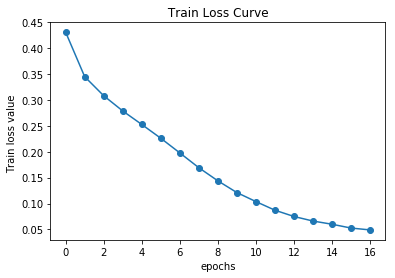

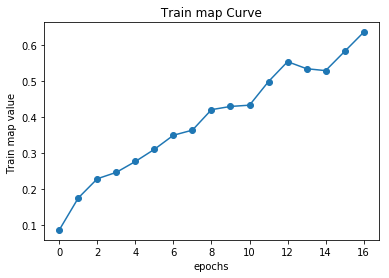

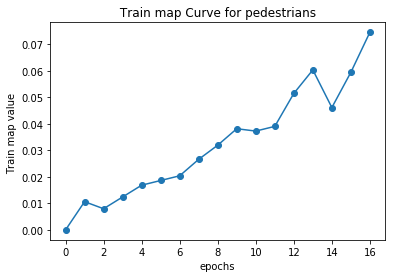

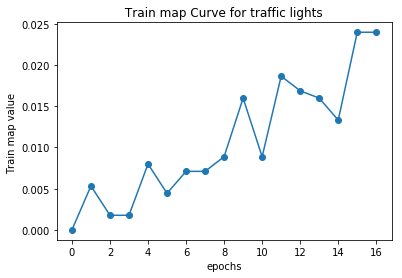

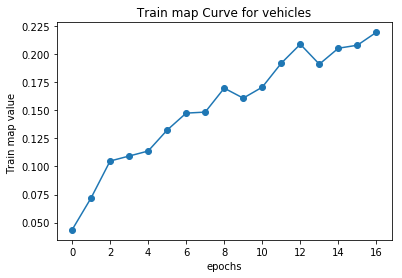

Epoch 17/50
Train Epoch: 17 [0/9000 (0%)]	Loss: 15.450364
train map is : 0.0
Train Epoch: 17 [160/9000 (2%)]	Loss: 11.186220
train map is : 0.45454545454545453
Train Epoch: 17 [320/9000 (4%)]	Loss: 9.551601
train map is : 0.5238095238095238
Train Epoch: 17 [480/9000 (5%)]	Loss: 14.698288
train map is : 0.5483870967741935
Train Epoch: 17 [640/9000 (7%)]	Loss: 14.240912
train map is : 0.5365853658536586
Train Epoch: 17 [800/9000 (9%)]	Loss: 12.760227
train map is : 0.6078431372549019
Train Epoch: 17 [960/9000 (11%)]	Loss: 10.499709
train map is : 0.5737704918032787
Train Epoch: 17 [1120/9000 (12%)]	Loss: 12.040261
train map is : 0.5774647887323944
Train Epoch: 17 [1280/9000 (14%)]	Loss: 14.610796
train map is : 0.5925925925925926
Train Epoch: 17 [1440/9000 (16%)]	Loss: 9.952606
train map is : 0.5824175824175825
Train Epoch: 17 [1600/9000 (18%)]	Loss: 25.105559
train map is : 0.594059405940594
Train Epoch: 17 [1760/9000 (20%)]	Loss: 15.012140
train map is : 0.5945945945945946
Train Epoch:

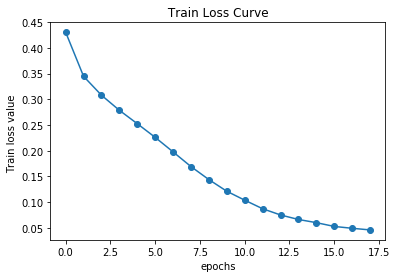

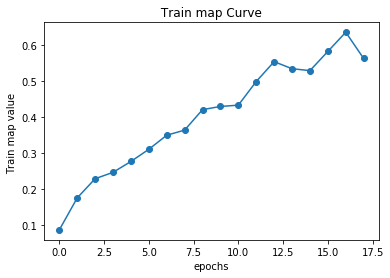

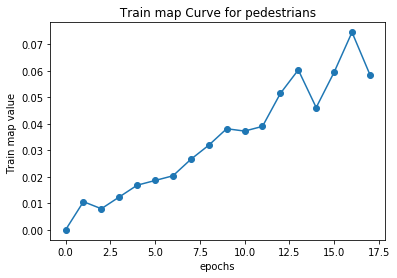

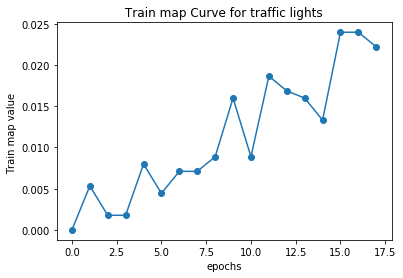

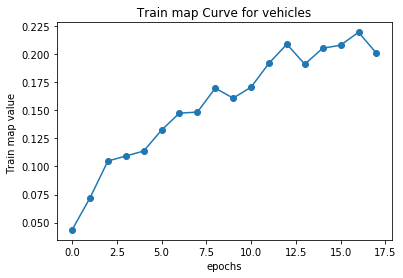

Epoch 18/50
Train Epoch: 18 [0/9000 (0%)]	Loss: 8.115077
train map is : 1.0
Train Epoch: 18 [160/9000 (2%)]	Loss: 11.907100
train map is : 0.6363636363636364
Train Epoch: 18 [320/9000 (4%)]	Loss: 12.531219
train map is : 0.6666666666666666
Train Epoch: 18 [480/9000 (5%)]	Loss: 10.862651
train map is : 0.6129032258064516
Train Epoch: 18 [640/9000 (7%)]	Loss: 11.776049
train map is : 0.6097560975609756
Train Epoch: 18 [800/9000 (9%)]	Loss: 10.923565
train map is : 0.6274509803921569
Train Epoch: 18 [960/9000 (11%)]	Loss: 8.156323
train map is : 0.5901639344262295
Train Epoch: 18 [1120/9000 (12%)]	Loss: 6.444171
train map is : 0.6056338028169014
Train Epoch: 18 [1280/9000 (14%)]	Loss: 9.573743
train map is : 0.5925925925925926
Train Epoch: 18 [1440/9000 (16%)]	Loss: 11.548044
train map is : 0.6263736263736264
Train Epoch: 18 [1600/9000 (18%)]	Loss: 9.499421
train map is : 0.6534653465346535
Train Epoch: 18 [1760/9000 (20%)]	Loss: 7.417575
train map is : 0.6756756756756757
Train Epoch: 18 

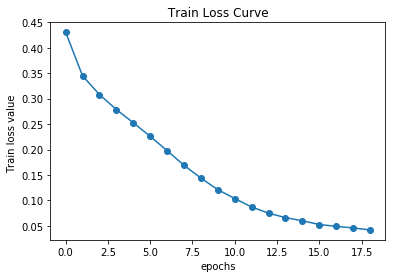

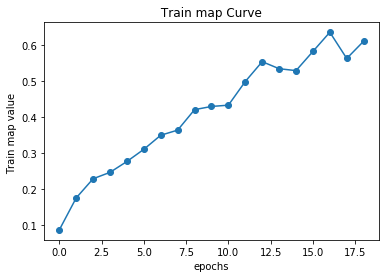

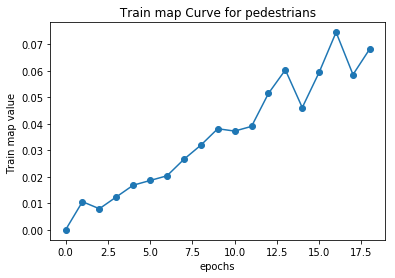

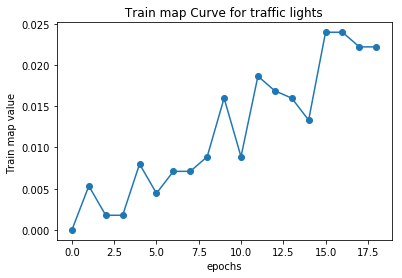

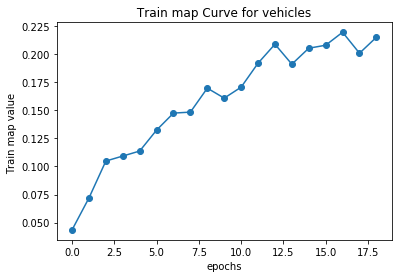

Epoch 19/50
Train Epoch: 19 [0/9000 (0%)]	Loss: 11.130663
train map is : 1.0
Train Epoch: 19 [160/9000 (2%)]	Loss: 12.684326
train map is : 1.0
Train Epoch: 19 [320/9000 (4%)]	Loss: 7.876554
train map is : 0.9047619047619048
Train Epoch: 19 [480/9000 (5%)]	Loss: 10.513625
train map is : 0.8064516129032258
Train Epoch: 19 [640/9000 (7%)]	Loss: 12.639404
train map is : 0.7317073170731707
Train Epoch: 19 [800/9000 (9%)]	Loss: 6.145382
train map is : 0.6666666666666666
Train Epoch: 19 [960/9000 (11%)]	Loss: 10.050161
train map is : 0.7049180327868853
Train Epoch: 19 [1120/9000 (12%)]	Loss: 7.759373
train map is : 0.7183098591549296
Train Epoch: 19 [1280/9000 (14%)]	Loss: 11.479427
train map is : 0.7160493827160493
Train Epoch: 19 [1440/9000 (16%)]	Loss: 8.566487
train map is : 0.6923076923076923
Train Epoch: 19 [1600/9000 (18%)]	Loss: 6.520248
train map is : 0.6831683168316832
Train Epoch: 19 [1760/9000 (20%)]	Loss: 10.421343
train map is : 0.6756756756756757
Train Epoch: 19 [1920/9000 (21

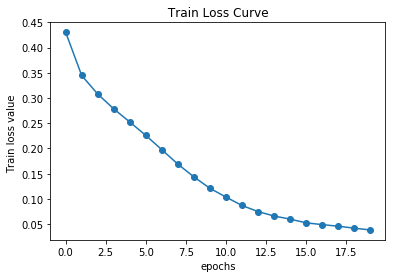

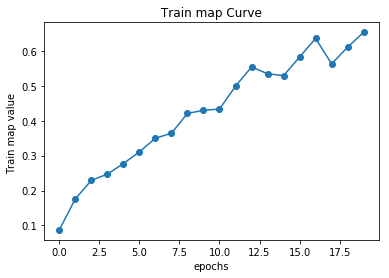

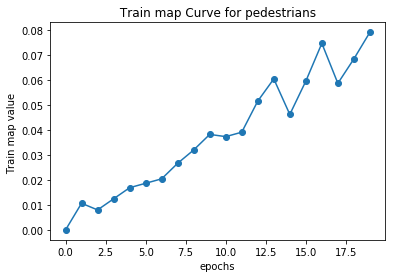

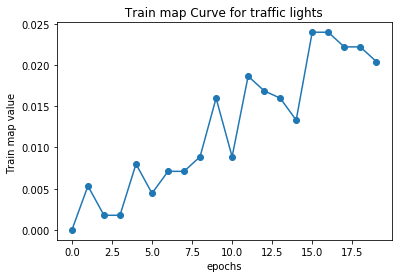

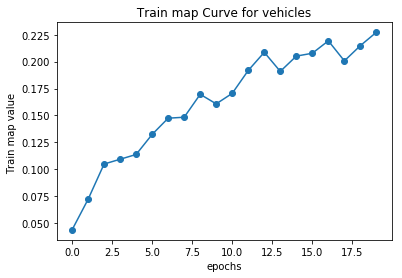

Epoch 20/50
Train Epoch: 20 [0/9000 (0%)]	Loss: 12.569667
train map is : 1.0
Train Epoch: 20 [160/9000 (2%)]	Loss: 5.381811
train map is : 0.7272727272727273
Train Epoch: 20 [320/9000 (4%)]	Loss: 7.880370
train map is : 0.7142857142857143
Train Epoch: 20 [480/9000 (5%)]	Loss: 10.734552
train map is : 0.5806451612903226
Train Epoch: 20 [640/9000 (7%)]	Loss: 9.288544
train map is : 0.5853658536585366
Train Epoch: 20 [800/9000 (9%)]	Loss: 10.471944
train map is : 0.6470588235294118
Train Epoch: 20 [960/9000 (11%)]	Loss: 12.596614
train map is : 0.639344262295082
Train Epoch: 20 [1120/9000 (12%)]	Loss: 11.782743
train map is : 0.647887323943662
Train Epoch: 20 [1280/9000 (14%)]	Loss: 6.886751
train map is : 0.6296296296296297
Train Epoch: 20 [1440/9000 (16%)]	Loss: 7.232624
train map is : 0.6373626373626373
Train Epoch: 20 [1600/9000 (18%)]	Loss: 8.524585
train map is : 0.6336633663366337
Train Epoch: 20 [1760/9000 (20%)]	Loss: 6.976532
train map is : 0.6396396396396397
Train Epoch: 20 [19

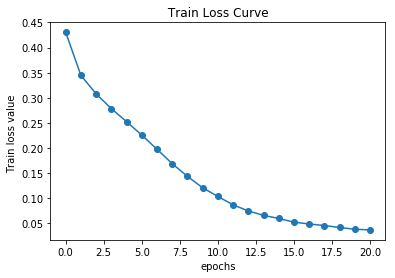

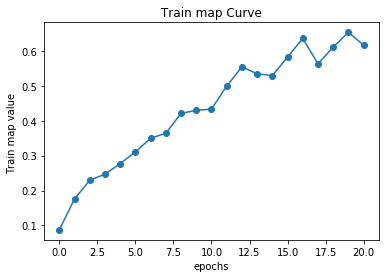

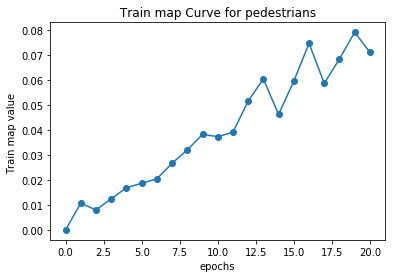

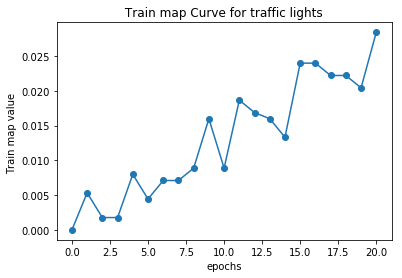

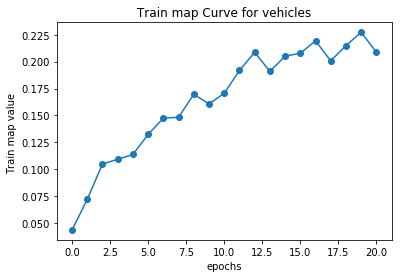

Epoch 21/50
Train Epoch: 21 [0/9000 (0%)]	Loss: 5.702558
train map is : 1.0
Train Epoch: 21 [160/9000 (2%)]	Loss: 11.042466
train map is : 0.6363636363636364
Train Epoch: 21 [320/9000 (4%)]	Loss: 9.156816
train map is : 0.8095238095238095
Train Epoch: 21 [480/9000 (5%)]	Loss: 7.375048
train map is : 0.7741935483870968
Train Epoch: 21 [640/9000 (7%)]	Loss: 4.228254
train map is : 0.7073170731707317
Train Epoch: 21 [800/9000 (9%)]	Loss: 9.955061
train map is : 0.6666666666666666
Train Epoch: 21 [960/9000 (11%)]	Loss: 8.916509
train map is : 0.6557377049180327
Train Epoch: 21 [1120/9000 (12%)]	Loss: 7.776825
train map is : 0.6901408450704225
Train Epoch: 21 [1280/9000 (14%)]	Loss: 9.625598
train map is : 0.6666666666666666
Train Epoch: 21 [1440/9000 (16%)]	Loss: 12.582722
train map is : 0.6483516483516484
Train Epoch: 21 [1600/9000 (18%)]	Loss: 5.772815
train map is : 0.6435643564356436
Train Epoch: 21 [1760/9000 (20%)]	Loss: 9.452277
train map is : 0.6216216216216216
Train Epoch: 21 [192

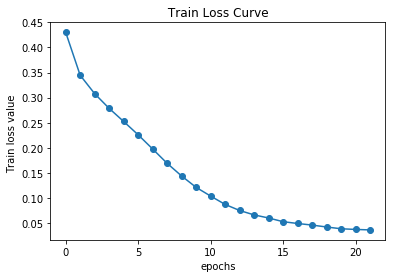

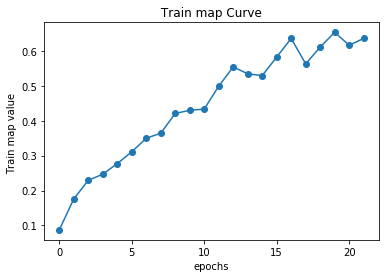

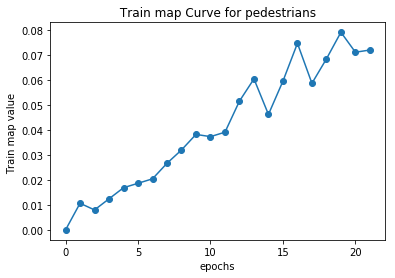

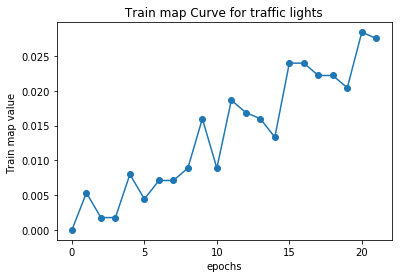

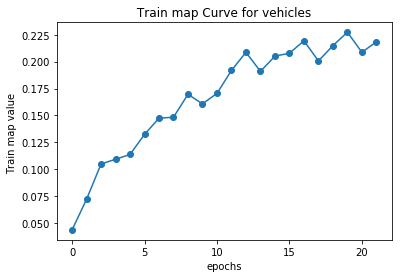

Epoch 22/50
Train Epoch: 22 [0/9000 (0%)]	Loss: 7.039343
train map is : 0.0
Train Epoch: 22 [160/9000 (2%)]	Loss: 10.680044
train map is : 0.6363636363636364
Train Epoch: 22 [320/9000 (4%)]	Loss: 6.111471
train map is : 0.6666666666666666
Train Epoch: 22 [480/9000 (5%)]	Loss: 6.880499
train map is : 0.6774193548387096
Train Epoch: 22 [640/9000 (7%)]	Loss: 12.775793
train map is : 0.6585365853658537
Train Epoch: 22 [800/9000 (9%)]	Loss: 8.494518
train map is : 0.6862745098039216
Train Epoch: 22 [960/9000 (11%)]	Loss: 6.457579
train map is : 0.6229508196721312
Train Epoch: 22 [1120/9000 (12%)]	Loss: 7.620594
train map is : 0.6197183098591549
Train Epoch: 22 [1280/9000 (14%)]	Loss: 7.215462
train map is : 0.6172839506172839
Train Epoch: 22 [1440/9000 (16%)]	Loss: 9.069233
train map is : 0.6373626373626373
Train Epoch: 22 [1600/9000 (18%)]	Loss: 8.660855
train map is : 0.6435643564356436
Train Epoch: 22 [1760/9000 (20%)]	Loss: 7.824647
train map is : 0.6756756756756757
Train Epoch: 22 [192

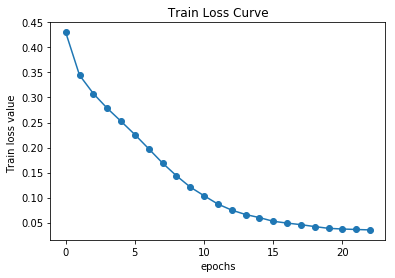

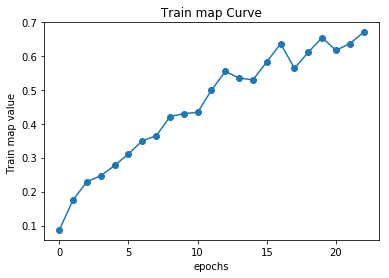

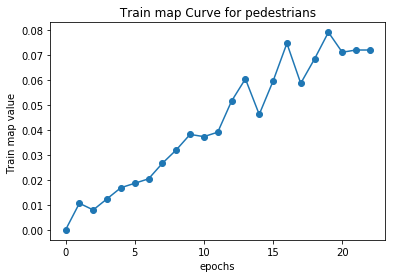

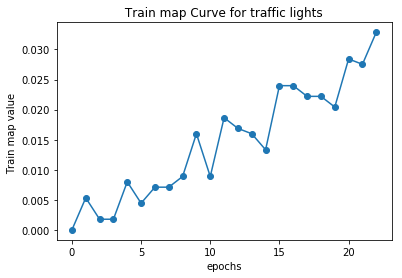

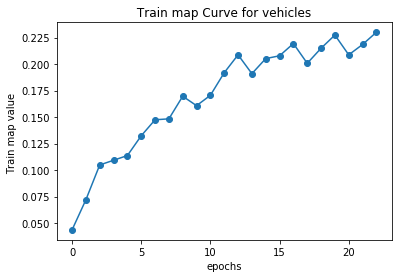

Epoch 23/50
Train Epoch: 23 [0/9000 (0%)]	Loss: 6.075303
train map is : 1.0
Train Epoch: 23 [160/9000 (2%)]	Loss: 8.041832
train map is : 0.9090909090909091
Train Epoch: 23 [320/9000 (4%)]	Loss: 5.760156
train map is : 0.8095238095238095
Train Epoch: 23 [480/9000 (5%)]	Loss: 7.877643
train map is : 0.7419354838709677
Train Epoch: 23 [640/9000 (7%)]	Loss: 9.639384
train map is : 0.7073170731707317
Train Epoch: 23 [800/9000 (9%)]	Loss: 12.329865
train map is : 0.6078431372549019
Train Epoch: 23 [960/9000 (11%)]	Loss: 11.551876
train map is : 0.6229508196721312
Train Epoch: 23 [1120/9000 (12%)]	Loss: 7.818078
train map is : 0.6619718309859155
Train Epoch: 23 [1280/9000 (14%)]	Loss: 8.588070
train map is : 0.691358024691358
Train Epoch: 23 [1440/9000 (16%)]	Loss: 8.678467
train map is : 0.6923076923076923
Train Epoch: 23 [1600/9000 (18%)]	Loss: 9.134834
train map is : 0.6831683168316832
Train Epoch: 23 [1760/9000 (20%)]	Loss: 8.680843
train map is : 0.6756756756756757
Train Epoch: 23 [1920

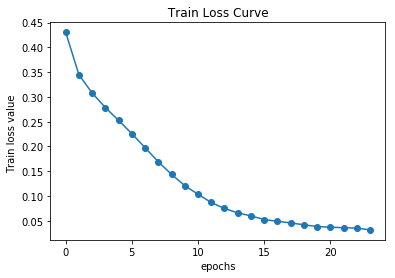

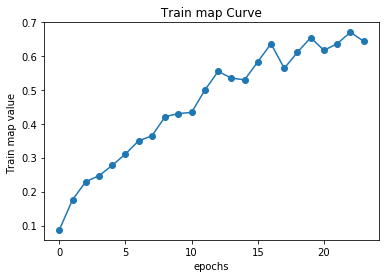

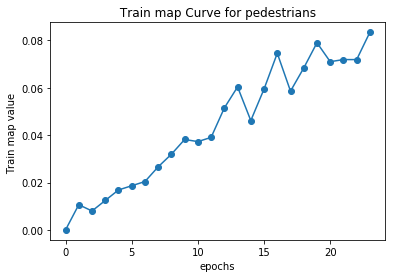

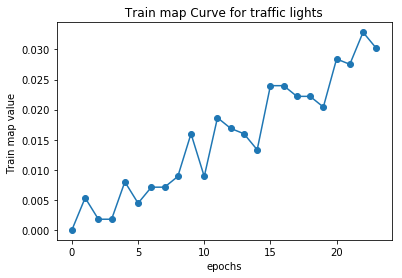

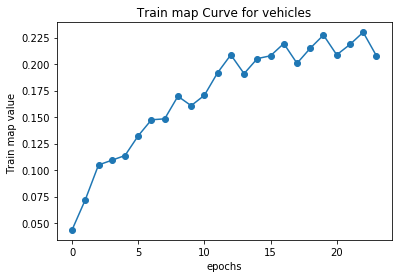

Epoch 24/50
Train Epoch: 24 [0/9000 (0%)]	Loss: 9.859195
train map is : 1.0
Train Epoch: 24 [160/9000 (2%)]	Loss: 8.125596
train map is : 0.5454545454545454
Train Epoch: 24 [320/9000 (4%)]	Loss: 5.216986
train map is : 0.5714285714285714
Train Epoch: 24 [480/9000 (5%)]	Loss: 4.936255
train map is : 0.6451612903225806
Train Epoch: 24 [640/9000 (7%)]	Loss: 6.907363
train map is : 0.6585365853658537
Train Epoch: 24 [800/9000 (9%)]	Loss: 8.706174
train map is : 0.6666666666666666
Train Epoch: 24 [960/9000 (11%)]	Loss: 5.271232
train map is : 0.6721311475409836
Train Epoch: 24 [1120/9000 (12%)]	Loss: 8.091693
train map is : 0.6619718309859155
Train Epoch: 24 [1280/9000 (14%)]	Loss: 7.710560
train map is : 0.654320987654321
Train Epoch: 24 [1440/9000 (16%)]	Loss: 7.361834
train map is : 0.6373626373626373
Train Epoch: 24 [1600/9000 (18%)]	Loss: 7.843311
train map is : 0.6633663366336634
Train Epoch: 24 [1760/9000 (20%)]	Loss: 13.423476
train map is : 0.6666666666666666
Train Epoch: 24 [1920/

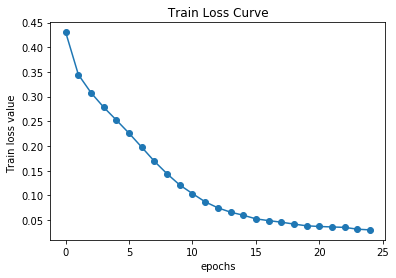

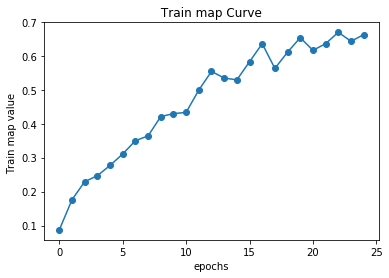

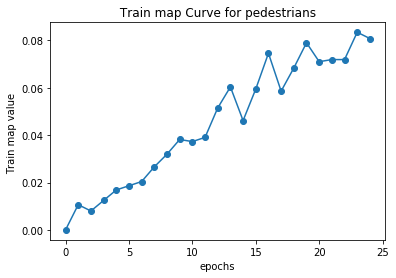

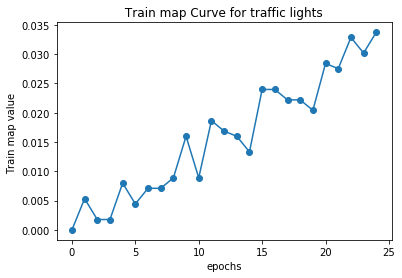

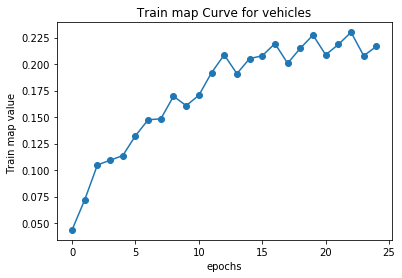

Epoch 25/50
Train Epoch: 25 [0/9000 (0%)]	Loss: 6.029549
train map is : 1.0
Train Epoch: 25 [160/9000 (2%)]	Loss: 8.960206
train map is : 0.6363636363636364
Train Epoch: 25 [320/9000 (4%)]	Loss: 6.403184
train map is : 0.6666666666666666
Train Epoch: 25 [480/9000 (5%)]	Loss: 6.413095
train map is : 0.6451612903225806
Train Epoch: 25 [640/9000 (7%)]	Loss: 9.331182
train map is : 0.6341463414634146
Train Epoch: 25 [800/9000 (9%)]	Loss: 7.023502
train map is : 0.6274509803921569
Train Epoch: 25 [960/9000 (11%)]	Loss: 7.026249
train map is : 0.6229508196721312
Train Epoch: 25 [1120/9000 (12%)]	Loss: 5.977415
train map is : 0.6197183098591549
Train Epoch: 25 [1280/9000 (14%)]	Loss: 7.771708
train map is : 0.6172839506172839
Train Epoch: 25 [1440/9000 (16%)]	Loss: 4.939206
train map is : 0.6263736263736264
Train Epoch: 25 [1600/9000 (18%)]	Loss: 4.016269
train map is : 0.6237623762376238
Train Epoch: 25 [1760/9000 (20%)]	Loss: 7.682026
train map is : 0.6306306306306306
Train Epoch: 25 [1920/

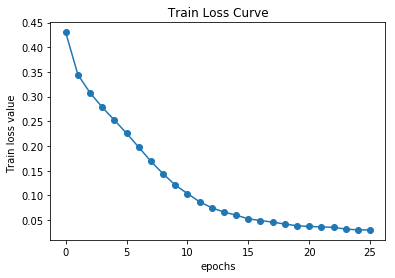

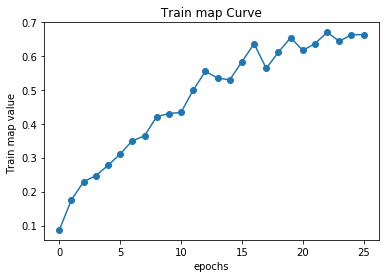

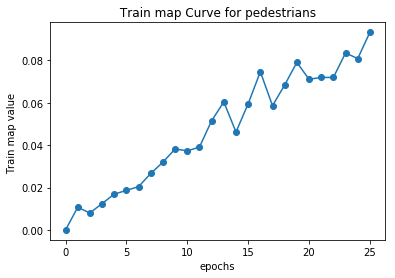

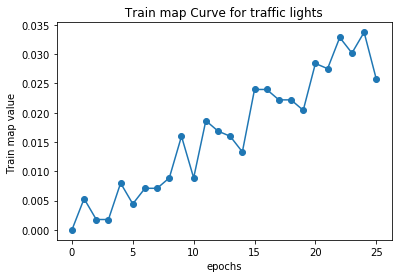

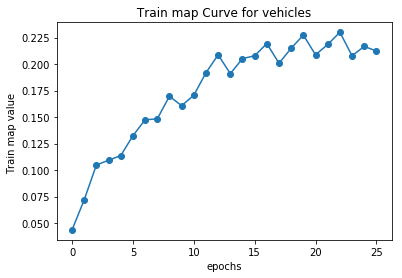

Epoch 26/50
Train Epoch: 26 [0/9000 (0%)]	Loss: 7.386562
train map is : 1.0
Train Epoch: 26 [160/9000 (2%)]	Loss: 7.708982
train map is : 0.5454545454545454
Train Epoch: 26 [320/9000 (4%)]	Loss: 7.316108
train map is : 0.7619047619047619
Train Epoch: 26 [480/9000 (5%)]	Loss: 8.638231
train map is : 0.7741935483870968
Train Epoch: 26 [640/9000 (7%)]	Loss: 6.137671
train map is : 0.7560975609756098
Train Epoch: 26 [800/9000 (9%)]	Loss: 8.329401
train map is : 0.7450980392156863
Train Epoch: 26 [960/9000 (11%)]	Loss: 6.679519
train map is : 0.7540983606557377
Train Epoch: 26 [1120/9000 (12%)]	Loss: 5.871705
train map is : 0.7323943661971831
Train Epoch: 26 [1280/9000 (14%)]	Loss: 5.469771
train map is : 0.7283950617283951
Train Epoch: 26 [1440/9000 (16%)]	Loss: 8.266457
train map is : 0.7252747252747253
Train Epoch: 26 [1600/9000 (18%)]	Loss: 6.397471
train map is : 0.7227722772277227
Train Epoch: 26 [1760/9000 (20%)]	Loss: 10.462841
train map is : 0.6936936936936937
Train Epoch: 26 [1920

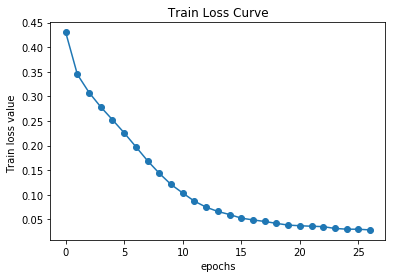

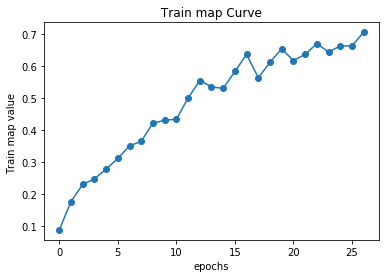

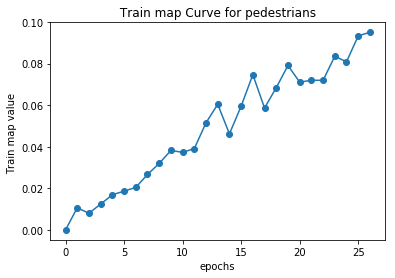

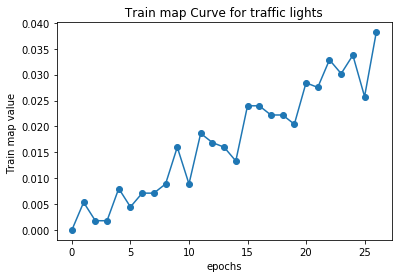

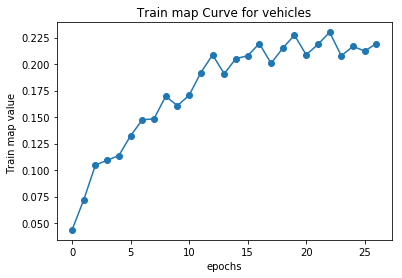

Epoch 27/50
Train Epoch: 27 [0/9000 (0%)]	Loss: 7.184889
train map is : 0.0
Train Epoch: 27 [160/9000 (2%)]	Loss: 6.852681
train map is : 0.6363636363636364
Train Epoch: 27 [320/9000 (4%)]	Loss: 4.510402
train map is : 0.7619047619047619
Train Epoch: 27 [480/9000 (5%)]	Loss: 6.300929
train map is : 0.7741935483870968
Train Epoch: 27 [640/9000 (7%)]	Loss: 6.491301
train map is : 0.7560975609756098
Train Epoch: 27 [800/9000 (9%)]	Loss: 7.165338
train map is : 0.7450980392156863
Train Epoch: 27 [960/9000 (11%)]	Loss: 4.249999
train map is : 0.7213114754098361
Train Epoch: 27 [1120/9000 (12%)]	Loss: 3.937382
train map is : 0.7183098591549296
Train Epoch: 27 [1280/9000 (14%)]	Loss: 4.424247
train map is : 0.691358024691358
Train Epoch: 27 [1440/9000 (16%)]	Loss: 4.577526
train map is : 0.6813186813186813
Train Epoch: 27 [1600/9000 (18%)]	Loss: 6.494469
train map is : 0.693069306930693
Train Epoch: 27 [1760/9000 (20%)]	Loss: 5.259721
train map is : 0.6846846846846847
Train Epoch: 27 [1920/90

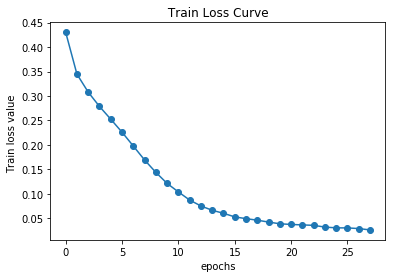

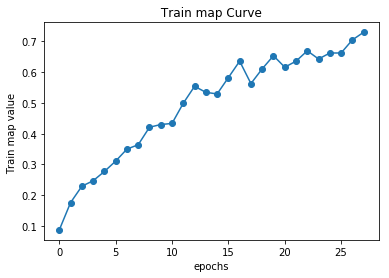

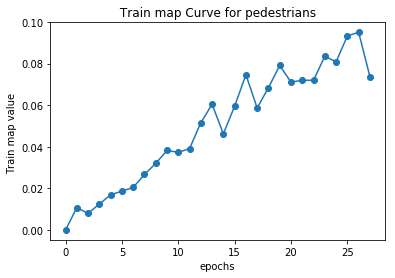

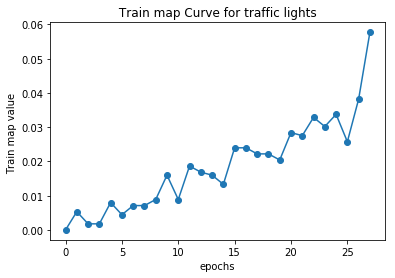

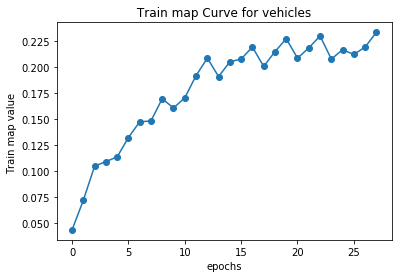

Epoch 28/50
Train Epoch: 28 [0/9000 (0%)]	Loss: 7.324429
train map is : 1.0
Train Epoch: 28 [160/9000 (2%)]	Loss: 4.128847
train map is : 0.6363636363636364
Train Epoch: 28 [320/9000 (4%)]	Loss: 5.210544
train map is : 0.7142857142857143
Train Epoch: 28 [480/9000 (5%)]	Loss: 14.412610
train map is : 0.6451612903225806
Train Epoch: 28 [640/9000 (7%)]	Loss: 5.875366
train map is : 0.6829268292682927
Train Epoch: 28 [800/9000 (9%)]	Loss: 11.921337
train map is : 0.7058823529411765
Train Epoch: 28 [960/9000 (11%)]	Loss: 4.322106
train map is : 0.7377049180327869
Train Epoch: 28 [1120/9000 (12%)]	Loss: 2.988959
train map is : 0.7605633802816901
Train Epoch: 28 [1280/9000 (14%)]	Loss: 8.417982
train map is : 0.7777777777777778
Train Epoch: 28 [1440/9000 (16%)]	Loss: 5.414278
train map is : 0.7802197802197802
Train Epoch: 28 [1600/9000 (18%)]	Loss: 6.041374
train map is : 0.7920792079207921
Train Epoch: 28 [1760/9000 (20%)]	Loss: 7.950317
train map is : 0.7747747747747747
Train Epoch: 28 [192

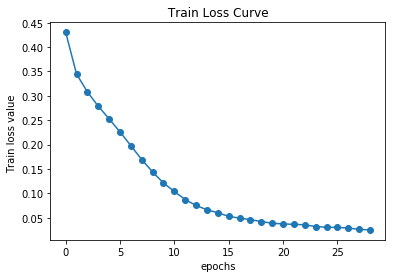

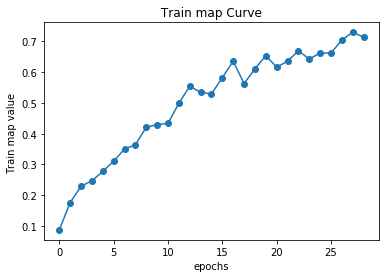

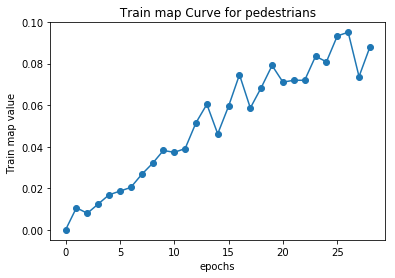

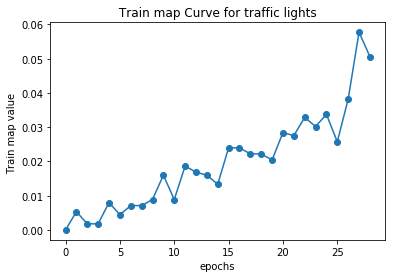

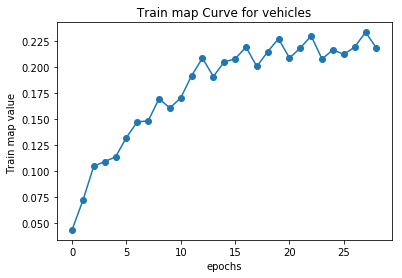

Epoch 29/50
Train Epoch: 29 [0/9000 (0%)]	Loss: 5.318107
train map is : 0.0
Train Epoch: 29 [160/9000 (2%)]	Loss: 4.763737
train map is : 0.8181818181818182
Train Epoch: 29 [320/9000 (4%)]	Loss: 2.811206
train map is : 0.7619047619047619
Train Epoch: 29 [480/9000 (5%)]	Loss: 2.874332
train map is : 0.7741935483870968
Train Epoch: 29 [640/9000 (7%)]	Loss: 3.396978
train map is : 0.7804878048780488
Train Epoch: 29 [800/9000 (9%)]	Loss: 4.897501
train map is : 0.7254901960784313
Train Epoch: 29 [960/9000 (11%)]	Loss: 3.281596
train map is : 0.7213114754098361
Train Epoch: 29 [1120/9000 (12%)]	Loss: 5.939380
train map is : 0.7183098591549296
Train Epoch: 29 [1280/9000 (14%)]	Loss: 4.300113
train map is : 0.7037037037037037
Train Epoch: 29 [1440/9000 (16%)]	Loss: 4.544637
train map is : 0.7032967032967034
Train Epoch: 29 [1600/9000 (18%)]	Loss: 7.173599
train map is : 0.7029702970297029
Train Epoch: 29 [1760/9000 (20%)]	Loss: 4.439433
train map is : 0.7117117117117117
Train Epoch: 29 [1920/

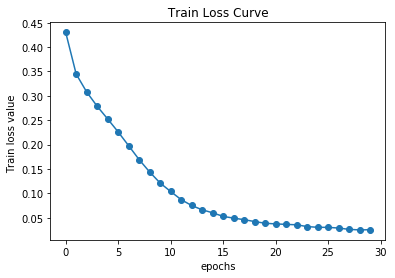

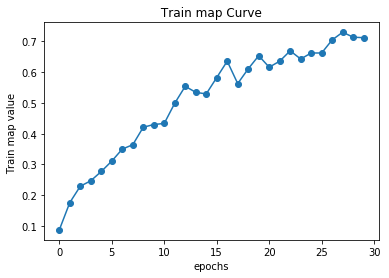

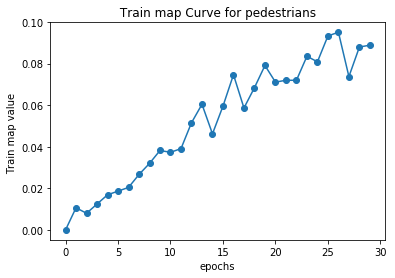

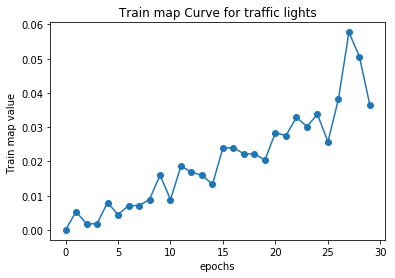

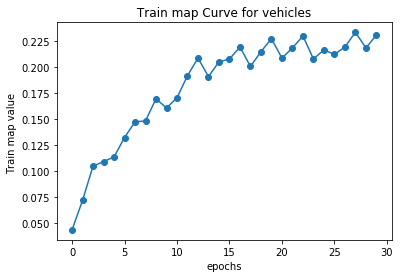

Epoch 30/50
Train Epoch: 30 [0/9000 (0%)]	Loss: 4.777886
train map is : 1.0
Train Epoch: 30 [160/9000 (2%)]	Loss: 8.404308
train map is : 0.8181818181818182
Train Epoch: 30 [320/9000 (4%)]	Loss: 5.846304
train map is : 0.6666666666666666
Train Epoch: 30 [480/9000 (5%)]	Loss: 6.595307
train map is : 0.7419354838709677
Train Epoch: 30 [640/9000 (7%)]	Loss: 6.362758
train map is : 0.7804878048780488
Train Epoch: 30 [800/9000 (9%)]	Loss: 8.471890
train map is : 0.7843137254901961
Train Epoch: 30 [960/9000 (11%)]	Loss: 5.191457
train map is : 0.7377049180327869
Train Epoch: 30 [1120/9000 (12%)]	Loss: 5.307491
train map is : 0.7605633802816901
Train Epoch: 30 [1280/9000 (14%)]	Loss: 8.043633
train map is : 0.7407407407407407
Train Epoch: 30 [1440/9000 (16%)]	Loss: 6.074056
train map is : 0.7362637362637363
Train Epoch: 30 [1600/9000 (18%)]	Loss: 4.898505
train map is : 0.7425742574257426
Train Epoch: 30 [1760/9000 (20%)]	Loss: 4.882745
train map is : 0.7297297297297297
Train Epoch: 30 [1920/

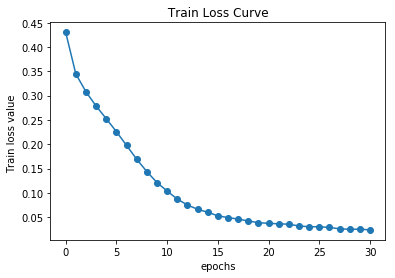

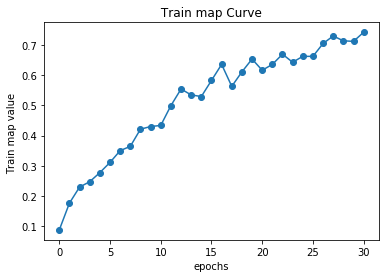

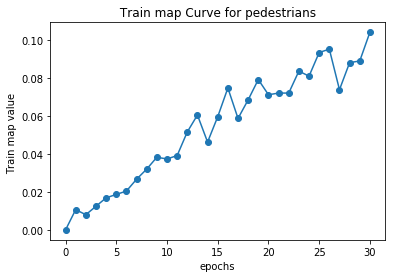

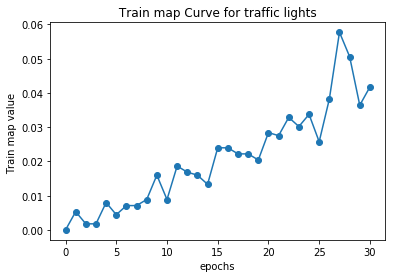

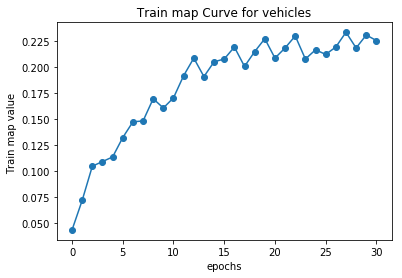

Epoch 31/50
Train Epoch: 31 [0/9000 (0%)]	Loss: 5.458659
train map is : 1.0
Train Epoch: 31 [160/9000 (2%)]	Loss: 2.531399
train map is : 0.45454545454545453
Train Epoch: 31 [320/9000 (4%)]	Loss: 5.066878
train map is : 0.6190476190476191
Train Epoch: 31 [480/9000 (5%)]	Loss: 5.931528
train map is : 0.6129032258064516
Train Epoch: 31 [640/9000 (7%)]	Loss: 4.517481
train map is : 0.6585365853658537
Train Epoch: 31 [800/9000 (9%)]	Loss: 3.411622
train map is : 0.7254901960784313
Train Epoch: 31 [960/9000 (11%)]	Loss: 6.146023
train map is : 0.7213114754098361
Train Epoch: 31 [1120/9000 (12%)]	Loss: 5.333213
train map is : 0.704225352112676
Train Epoch: 31 [1280/9000 (14%)]	Loss: 4.472181
train map is : 0.691358024691358
Train Epoch: 31 [1440/9000 (16%)]	Loss: 5.708832
train map is : 0.7032967032967034
Train Epoch: 31 [1600/9000 (18%)]	Loss: 7.603699
train map is : 0.7029702970297029
Train Epoch: 31 [1760/9000 (20%)]	Loss: 5.267868
train map is : 0.7117117117117117
Train Epoch: 31 [1920/9

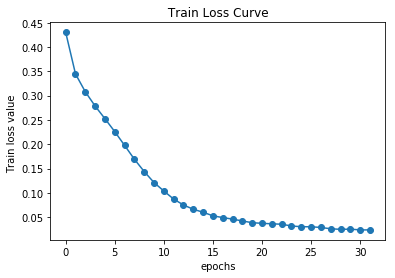

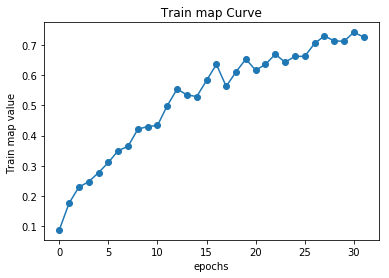

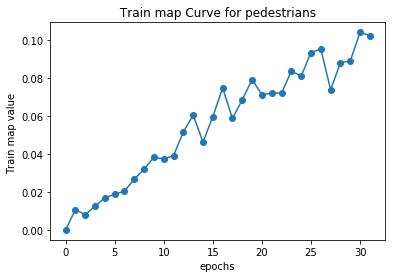

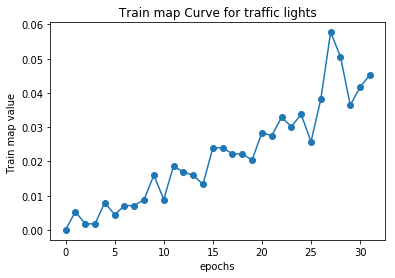

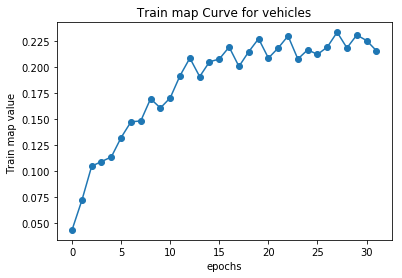

Epoch 32/50
Train Epoch: 32 [0/9000 (0%)]	Loss: 4.686416
train map is : 1.0
Train Epoch: 32 [160/9000 (2%)]	Loss: 4.508076
train map is : 0.9090909090909091
Train Epoch: 32 [320/9000 (4%)]	Loss: 5.786818
train map is : 0.8571428571428571
Train Epoch: 32 [480/9000 (5%)]	Loss: 4.025253
train map is : 0.8064516129032258
Train Epoch: 32 [640/9000 (7%)]	Loss: 6.660729
train map is : 0.8292682926829268
Train Epoch: 32 [800/9000 (9%)]	Loss: 14.293809
train map is : 0.7647058823529411
Train Epoch: 32 [960/9000 (11%)]	Loss: 5.439272
train map is : 0.7377049180327869
Train Epoch: 32 [1120/9000 (12%)]	Loss: 11.871255
train map is : 0.7323943661971831
Train Epoch: 32 [1280/9000 (14%)]	Loss: 6.848556
train map is : 0.7283950617283951
Train Epoch: 32 [1440/9000 (16%)]	Loss: 3.554938
train map is : 0.7362637362637363
Train Epoch: 32 [1600/9000 (18%)]	Loss: 4.436886
train map is : 0.7425742574257426
Train Epoch: 32 [1760/9000 (20%)]	Loss: 5.980184
train map is : 0.7477477477477478
Train Epoch: 32 [192

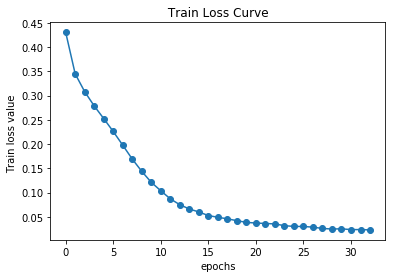

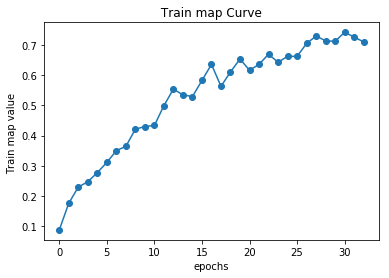

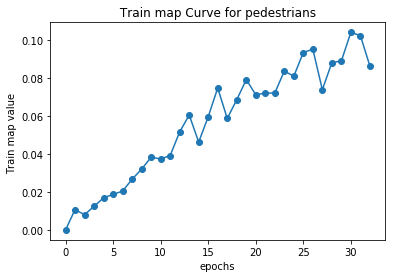

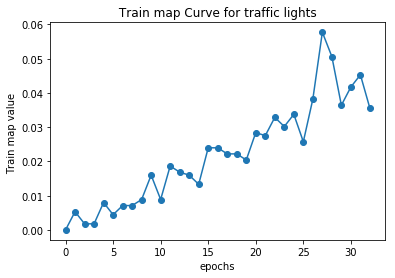

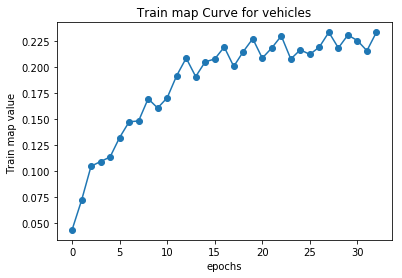

Epoch 33/50
Train Epoch: 33 [0/9000 (0%)]	Loss: 4.759537
train map is : 1.0
Train Epoch: 33 [160/9000 (2%)]	Loss: 4.269544
train map is : 0.7272727272727273
Train Epoch: 33 [320/9000 (4%)]	Loss: 5.535338
train map is : 0.7142857142857143
Train Epoch: 33 [480/9000 (5%)]	Loss: 5.140287
train map is : 0.7419354838709677
Train Epoch: 33 [640/9000 (7%)]	Loss: 6.561351
train map is : 0.7804878048780488
Train Epoch: 33 [800/9000 (9%)]	Loss: 5.409781
train map is : 0.803921568627451
Train Epoch: 33 [960/9000 (11%)]	Loss: 3.897532
train map is : 0.7704918032786885
Train Epoch: 33 [1120/9000 (12%)]	Loss: 3.667372
train map is : 0.7323943661971831
Train Epoch: 33 [1280/9000 (14%)]	Loss: 3.976118
train map is : 0.7283950617283951
Train Epoch: 33 [1440/9000 (16%)]	Loss: 5.775046
train map is : 0.7362637362637363
Train Epoch: 33 [1600/9000 (18%)]	Loss: 4.765433
train map is : 0.7425742574257426
Train Epoch: 33 [1760/9000 (20%)]	Loss: 6.931822
train map is : 0.7297297297297297
Train Epoch: 33 [1920/9

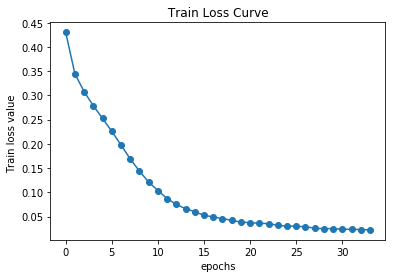

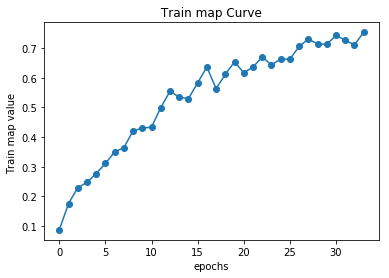

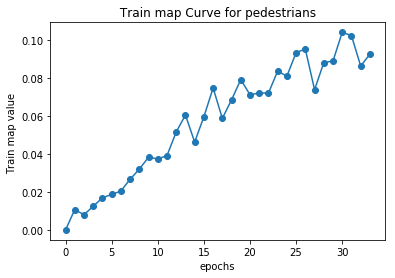

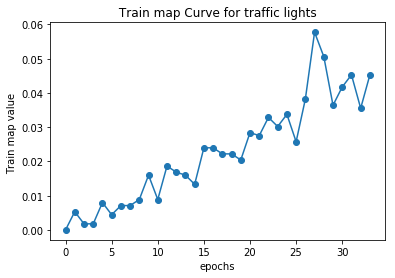

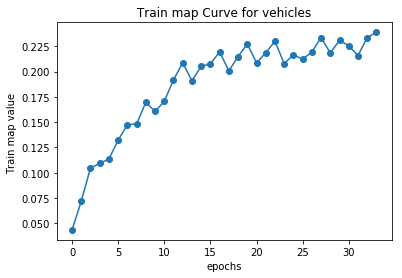

Epoch 34/50
Train Epoch: 34 [0/9000 (0%)]	Loss: 4.784981
train map is : 0.0
Train Epoch: 34 [160/9000 (2%)]	Loss: 5.847658
train map is : 0.9090909090909091
Train Epoch: 34 [320/9000 (4%)]	Loss: 6.134014
train map is : 0.9047619047619048
Train Epoch: 34 [480/9000 (5%)]	Loss: 5.872212
train map is : 0.8064516129032258
Train Epoch: 34 [640/9000 (7%)]	Loss: 3.199170
train map is : 0.8292682926829268
Train Epoch: 34 [800/9000 (9%)]	Loss: 10.258024
train map is : 0.8235294117647058
Train Epoch: 34 [960/9000 (11%)]	Loss: 5.766410
train map is : 0.8032786885245902
Train Epoch: 34 [1120/9000 (12%)]	Loss: 6.510855
train map is : 0.8169014084507042
Train Epoch: 34 [1280/9000 (14%)]	Loss: 5.372857
train map is : 0.8024691358024691
Train Epoch: 34 [1440/9000 (16%)]	Loss: 3.424138
train map is : 0.8131868131868132
Train Epoch: 34 [1600/9000 (18%)]	Loss: 3.396020
train map is : 0.8217821782178217
Train Epoch: 34 [1760/9000 (20%)]	Loss: 6.866234
train map is : 0.8018018018018018
Train Epoch: 34 [1920

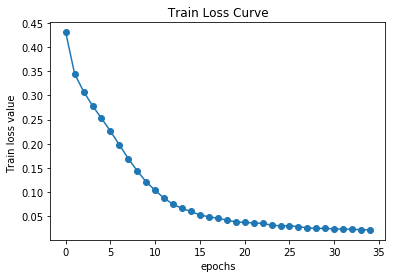

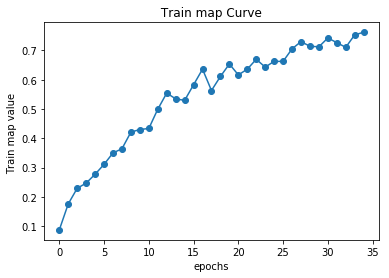

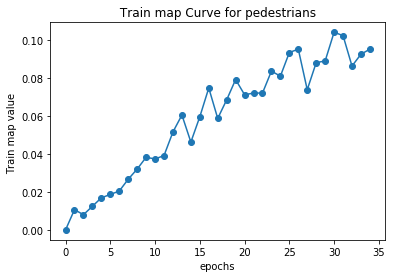

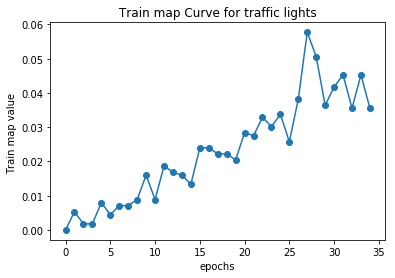

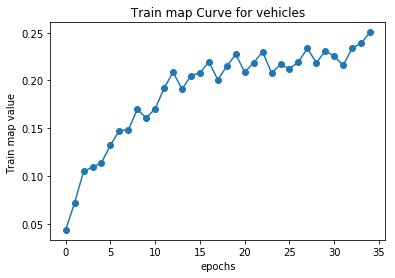

Epoch 35/50
Train Epoch: 35 [0/9000 (0%)]	Loss: 5.075259
train map is : 1.0
Train Epoch: 35 [160/9000 (2%)]	Loss: 4.530455
train map is : 0.5454545454545454
Train Epoch: 35 [320/9000 (4%)]	Loss: 6.623274
train map is : 0.5714285714285714
Train Epoch: 35 [480/9000 (5%)]	Loss: 3.890552
train map is : 0.6774193548387096
Train Epoch: 35 [640/9000 (7%)]	Loss: 2.611022
train map is : 0.7073170731707317
Train Epoch: 35 [800/9000 (9%)]	Loss: 5.896613
train map is : 0.7450980392156863
Train Epoch: 35 [960/9000 (11%)]	Loss: 3.009011
train map is : 0.7049180327868853
Train Epoch: 35 [1120/9000 (12%)]	Loss: 4.193007
train map is : 0.7183098591549296
Train Epoch: 35 [1280/9000 (14%)]	Loss: 5.700042
train map is : 0.7160493827160493
Train Epoch: 35 [1440/9000 (16%)]	Loss: 7.436063
train map is : 0.7252747252747253
Train Epoch: 35 [1600/9000 (18%)]	Loss: 5.910630
train map is : 0.7524752475247525
Train Epoch: 35 [1760/9000 (20%)]	Loss: 9.060125
train map is : 0.7477477477477478
Train Epoch: 35 [1920/

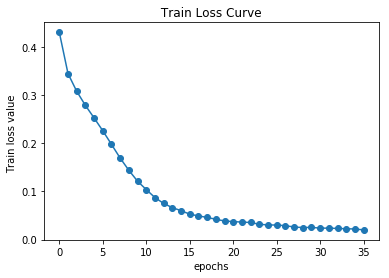

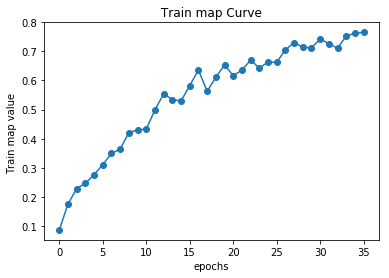

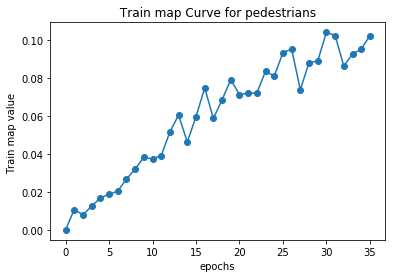

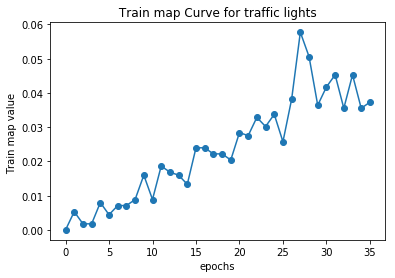

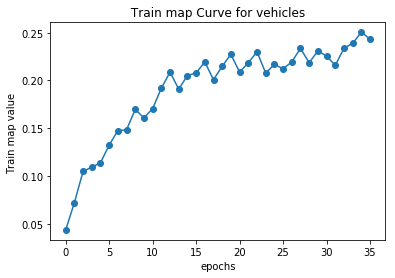

Epoch 36/50
Train Epoch: 36 [0/9000 (0%)]	Loss: 3.790107
train map is : 1.0
Train Epoch: 36 [160/9000 (2%)]	Loss: 2.522011
train map is : 0.6363636363636364
Train Epoch: 36 [320/9000 (4%)]	Loss: 4.071344
train map is : 0.7142857142857143
Train Epoch: 36 [480/9000 (5%)]	Loss: 4.940374
train map is : 0.7096774193548387
Train Epoch: 36 [640/9000 (7%)]	Loss: 4.552686
train map is : 0.6829268292682927
Train Epoch: 36 [800/9000 (9%)]	Loss: 3.900018
train map is : 0.7254901960784313
Train Epoch: 36 [960/9000 (11%)]	Loss: 6.431283
train map is : 0.7377049180327869
Train Epoch: 36 [1120/9000 (12%)]	Loss: 2.519712
train map is : 0.7323943661971831
Train Epoch: 36 [1280/9000 (14%)]	Loss: 3.938138
train map is : 0.7530864197530864
Train Epoch: 36 [1440/9000 (16%)]	Loss: 9.332477
train map is : 0.7582417582417582
Train Epoch: 36 [1600/9000 (18%)]	Loss: 4.136603
train map is : 0.7722772277227723
Train Epoch: 36 [1760/9000 (20%)]	Loss: 2.687970
train map is : 0.7477477477477478
Train Epoch: 36 [1920/

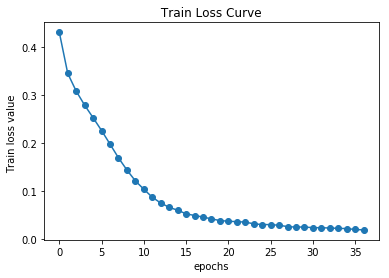

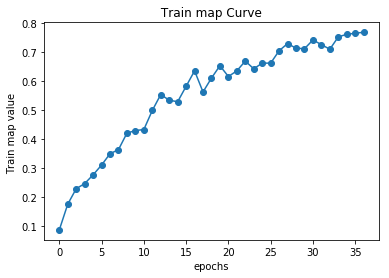

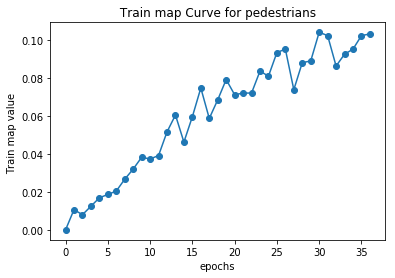

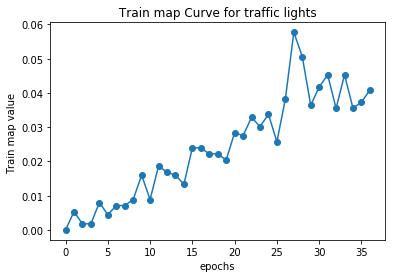

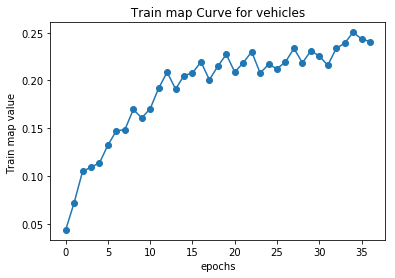

Epoch 37/50
Train Epoch: 37 [0/9000 (0%)]	Loss: 4.565317
train map is : 1.0
Train Epoch: 37 [160/9000 (2%)]	Loss: 2.885486
train map is : 0.6363636363636364
Train Epoch: 37 [320/9000 (4%)]	Loss: 4.305525
train map is : 0.6190476190476191
Train Epoch: 37 [480/9000 (5%)]	Loss: 3.267249
train map is : 0.6774193548387096
Train Epoch: 37 [640/9000 (7%)]	Loss: 2.434532
train map is : 0.7317073170731707
Train Epoch: 37 [800/9000 (9%)]	Loss: 4.820369
train map is : 0.7450980392156863
Train Epoch: 37 [960/9000 (11%)]	Loss: 4.628817
train map is : 0.7213114754098361
Train Epoch: 37 [1120/9000 (12%)]	Loss: 6.425603
train map is : 0.7464788732394366
Train Epoch: 37 [1280/9000 (14%)]	Loss: 5.714689
train map is : 0.7530864197530864
Train Epoch: 37 [1440/9000 (16%)]	Loss: 4.642979
train map is : 0.7582417582417582
Train Epoch: 37 [1600/9000 (18%)]	Loss: 5.499683
train map is : 0.7425742574257426
Train Epoch: 37 [1760/9000 (20%)]	Loss: 5.599018
train map is : 0.7567567567567568
Train Epoch: 37 [1920/

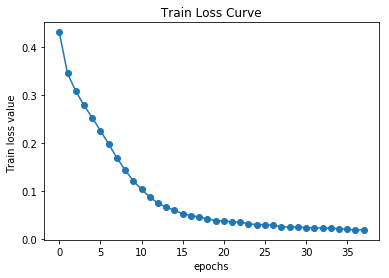

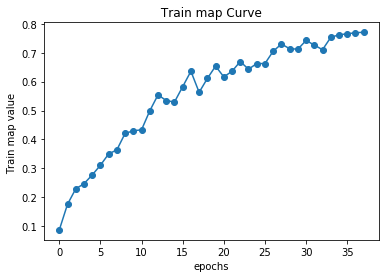

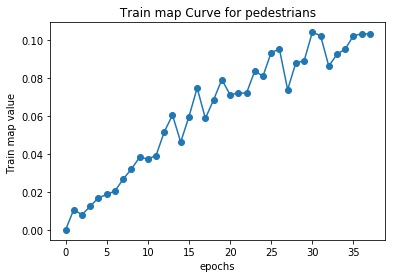

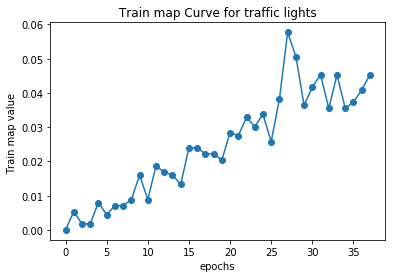

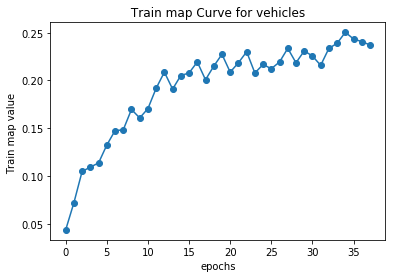

Epoch 38/50
Train Epoch: 38 [0/9000 (0%)]	Loss: 3.261288
train map is : 1.0
Train Epoch: 38 [160/9000 (2%)]	Loss: 5.223654
train map is : 0.7272727272727273
Train Epoch: 38 [320/9000 (4%)]	Loss: 1.951827
train map is : 0.7619047619047619
Train Epoch: 38 [480/9000 (5%)]	Loss: 2.422421
train map is : 0.7419354838709677
Train Epoch: 38 [640/9000 (7%)]	Loss: 2.533042
train map is : 0.7073170731707317
Train Epoch: 38 [800/9000 (9%)]	Loss: 4.548344
train map is : 0.7058823529411765
Train Epoch: 38 [960/9000 (11%)]	Loss: 5.545693
train map is : 0.7540983606557377
Train Epoch: 38 [1120/9000 (12%)]	Loss: 2.773315
train map is : 0.7887323943661971
Train Epoch: 38 [1280/9000 (14%)]	Loss: 3.774605
train map is : 0.8024691358024691
Train Epoch: 38 [1440/9000 (16%)]	Loss: 4.278195
train map is : 0.7912087912087912
Train Epoch: 38 [1600/9000 (18%)]	Loss: 3.290927
train map is : 0.7920792079207921
Train Epoch: 38 [1760/9000 (20%)]	Loss: 7.825225
train map is : 0.8108108108108109
Train Epoch: 38 [1920/

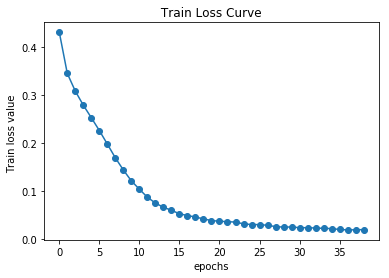

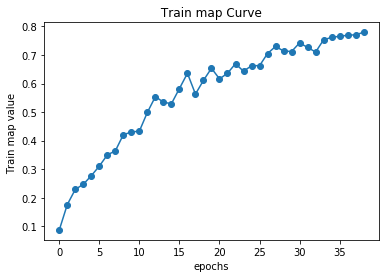

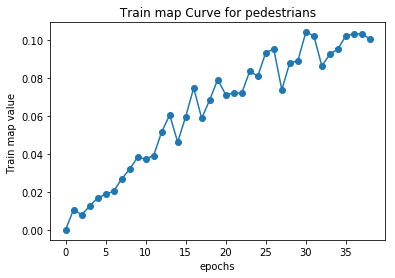

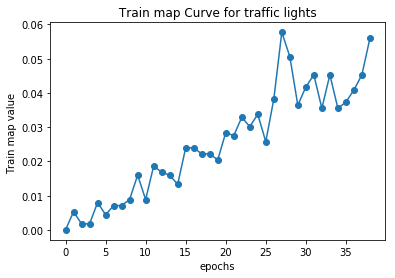

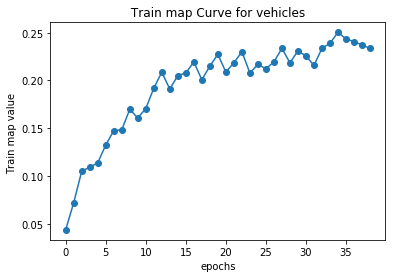

Epoch 39/50
Train Epoch: 39 [0/9000 (0%)]	Loss: 5.757904
train map is : 1.0
Train Epoch: 39 [160/9000 (2%)]	Loss: 7.964882
train map is : 0.8181818181818182
Train Epoch: 39 [320/9000 (4%)]	Loss: 4.447118
train map is : 0.8095238095238095
Train Epoch: 39 [480/9000 (5%)]	Loss: 4.509862
train map is : 0.8387096774193549
Train Epoch: 39 [640/9000 (7%)]	Loss: 3.746440
train map is : 0.8536585365853658
Train Epoch: 39 [800/9000 (9%)]	Loss: 4.313771
train map is : 0.803921568627451
Train Epoch: 39 [960/9000 (11%)]	Loss: 4.135826
train map is : 0.7868852459016393
Train Epoch: 39 [1120/9000 (12%)]	Loss: 3.438105
train map is : 0.7746478873239436
Train Epoch: 39 [1280/9000 (14%)]	Loss: 3.772671
train map is : 0.7530864197530864
Train Epoch: 39 [1440/9000 (16%)]	Loss: 3.147252
train map is : 0.7692307692307693
Train Epoch: 39 [1600/9000 (18%)]	Loss: 2.625502
train map is : 0.7425742574257426
Train Epoch: 39 [1760/9000 (20%)]	Loss: 6.952000
train map is : 0.7387387387387387
Train Epoch: 39 [1920/9

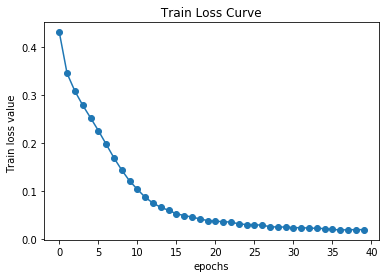

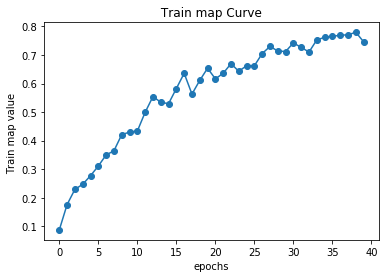

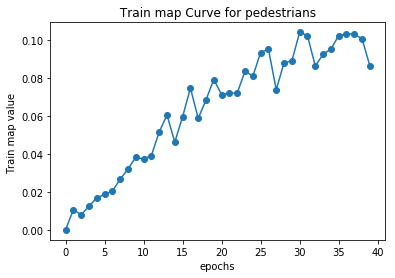

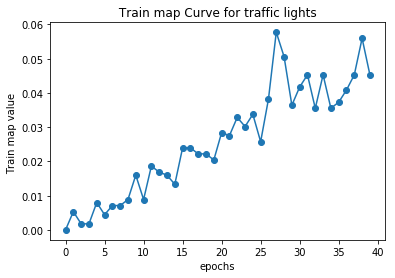

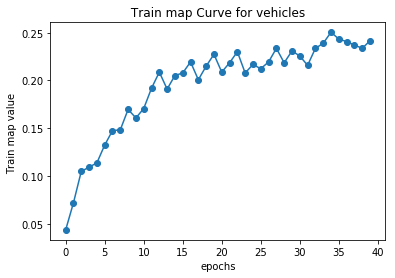

Epoch 40/50
Train Epoch: 40 [0/9000 (0%)]	Loss: 5.529992
train map is : 0.0
Train Epoch: 40 [160/9000 (2%)]	Loss: 4.950011
train map is : 0.5454545454545454
Train Epoch: 40 [320/9000 (4%)]	Loss: 4.330883
train map is : 0.7619047619047619
Train Epoch: 40 [480/9000 (5%)]	Loss: 4.695809
train map is : 0.8064516129032258
Train Epoch: 40 [640/9000 (7%)]	Loss: 2.858849
train map is : 0.8292682926829268
Train Epoch: 40 [800/9000 (9%)]	Loss: 6.180593
train map is : 0.8235294117647058
Train Epoch: 40 [960/9000 (11%)]	Loss: 6.086076
train map is : 0.8032786885245902
Train Epoch: 40 [1120/9000 (12%)]	Loss: 5.272737
train map is : 0.7887323943661971
Train Epoch: 40 [1280/9000 (14%)]	Loss: 6.922245
train map is : 0.7901234567901234
Train Epoch: 40 [1440/9000 (16%)]	Loss: 3.587073
train map is : 0.7912087912087912
Train Epoch: 40 [1600/9000 (18%)]	Loss: 5.016607
train map is : 0.801980198019802
Train Epoch: 40 [1760/9000 (20%)]	Loss: 3.656794
train map is : 0.7927927927927928
Train Epoch: 40 [1920/9

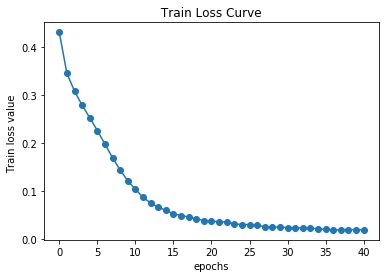

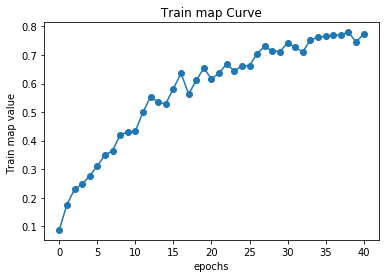

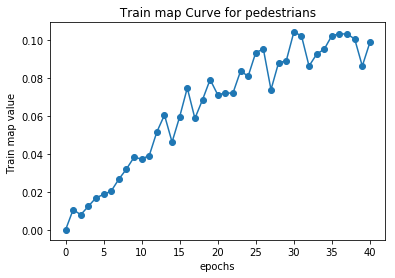

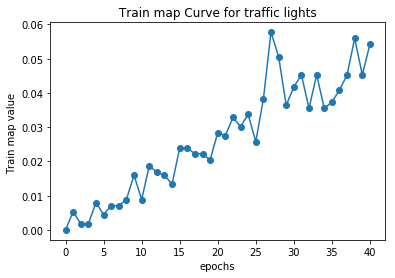

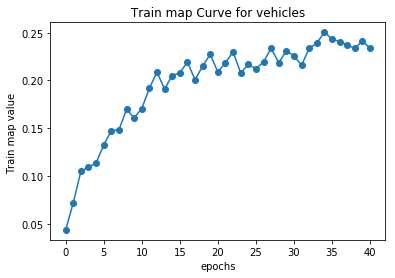

Epoch 41/50
Train Epoch: 41 [0/9000 (0%)]	Loss: 7.553283
train map is : 1.0
Train Epoch: 41 [160/9000 (2%)]	Loss: 5.431945
train map is : 0.7272727272727273
Train Epoch: 41 [320/9000 (4%)]	Loss: 2.699640
train map is : 0.8095238095238095
Train Epoch: 41 [480/9000 (5%)]	Loss: 5.974942
train map is : 0.8709677419354839
Train Epoch: 41 [640/9000 (7%)]	Loss: 5.282673
train map is : 0.8292682926829268
Train Epoch: 41 [800/9000 (9%)]	Loss: 4.433794
train map is : 0.8431372549019608
Train Epoch: 41 [960/9000 (11%)]	Loss: 3.829705
train map is : 0.8032786885245902
Train Epoch: 41 [1120/9000 (12%)]	Loss: 5.311304
train map is : 0.8028169014084507
Train Epoch: 41 [1280/9000 (14%)]	Loss: 4.123241
train map is : 0.7777777777777778
Train Epoch: 41 [1440/9000 (16%)]	Loss: 5.481439
train map is : 0.7802197802197802
Train Epoch: 41 [1600/9000 (18%)]	Loss: 4.163155
train map is : 0.7821782178217822
Train Epoch: 41 [1760/9000 (20%)]	Loss: 4.481721
train map is : 0.7657657657657657
Train Epoch: 41 [1920/

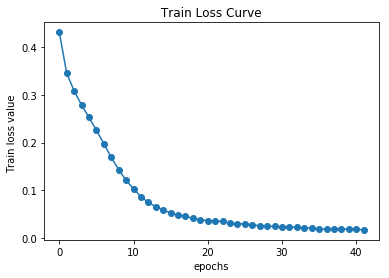

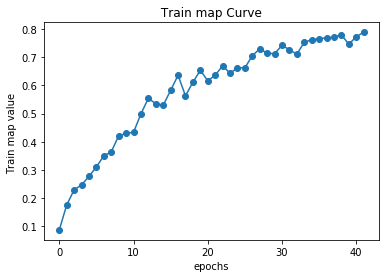

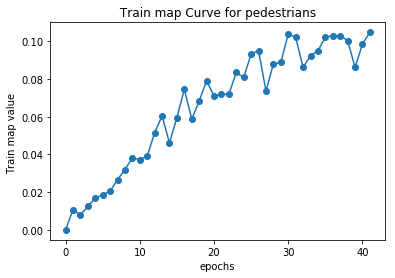

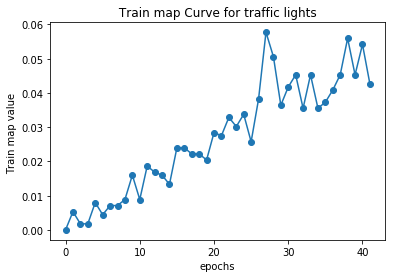

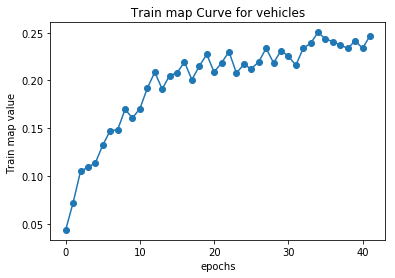

Epoch 42/50
Train Epoch: 42 [0/9000 (0%)]	Loss: 3.445705
train map is : 0.0
Train Epoch: 42 [160/9000 (2%)]	Loss: 6.000965
train map is : 0.6363636363636364
Train Epoch: 42 [320/9000 (4%)]	Loss: 6.637850
train map is : 0.7619047619047619
Train Epoch: 42 [480/9000 (5%)]	Loss: 5.130386
train map is : 0.8387096774193549
Train Epoch: 42 [640/9000 (7%)]	Loss: 4.613250
train map is : 0.8292682926829268
Train Epoch: 42 [800/9000 (9%)]	Loss: 6.606049
train map is : 0.8235294117647058
Train Epoch: 42 [960/9000 (11%)]	Loss: 5.804565
train map is : 0.819672131147541
Train Epoch: 42 [1120/9000 (12%)]	Loss: 4.067276
train map is : 0.8309859154929577
Train Epoch: 42 [1280/9000 (14%)]	Loss: 4.171557
train map is : 0.8271604938271605
Train Epoch: 42 [1440/9000 (16%)]	Loss: 3.613819
train map is : 0.8241758241758241
Train Epoch: 42 [1600/9000 (18%)]	Loss: 2.202846
train map is : 0.8316831683168316
Train Epoch: 42 [1760/9000 (20%)]	Loss: 5.135321
train map is : 0.8378378378378378
Train Epoch: 42 [1920/9

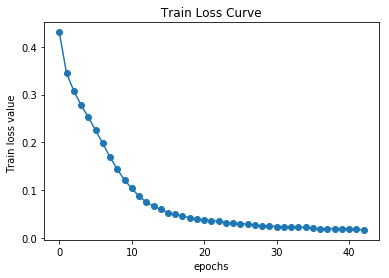

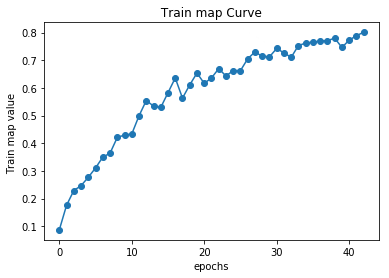

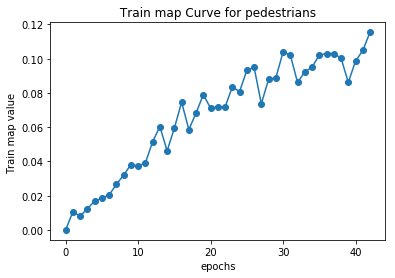

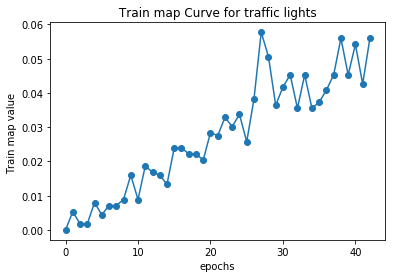

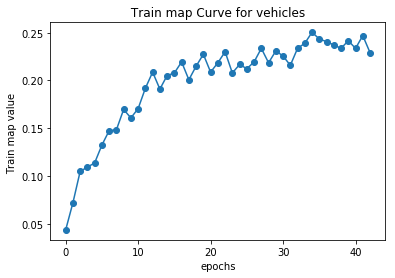

Epoch 43/50
Train Epoch: 43 [0/9000 (0%)]	Loss: 1.925500
train map is : 1.0
Train Epoch: 43 [160/9000 (2%)]	Loss: 4.529173
train map is : 0.8181818181818182
Train Epoch: 43 [320/9000 (4%)]	Loss: 6.916289
train map is : 0.8095238095238095
Train Epoch: 43 [480/9000 (5%)]	Loss: 6.778512
train map is : 0.8709677419354839
Train Epoch: 43 [640/9000 (7%)]	Loss: 4.137246
train map is : 0.8780487804878049
Train Epoch: 43 [800/9000 (9%)]	Loss: 3.522112
train map is : 0.8431372549019608
Train Epoch: 43 [960/9000 (11%)]	Loss: 2.499507
train map is : 0.819672131147541
Train Epoch: 43 [1120/9000 (12%)]	Loss: 7.025220
train map is : 0.8028169014084507
Train Epoch: 43 [1280/9000 (14%)]	Loss: 4.571639
train map is : 0.8024691358024691
Train Epoch: 43 [1440/9000 (16%)]	Loss: 5.815422
train map is : 0.7912087912087912
Train Epoch: 43 [1600/9000 (18%)]	Loss: 1.992547
train map is : 0.7920792079207921
Train Epoch: 43 [1760/9000 (20%)]	Loss: 3.722338
train map is : 0.8018018018018018
Train Epoch: 43 [1920/9

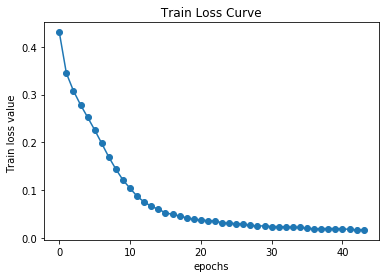

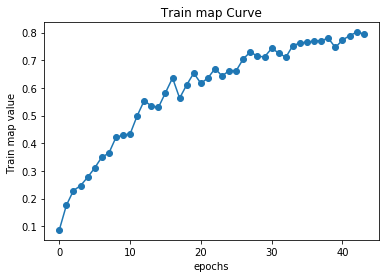

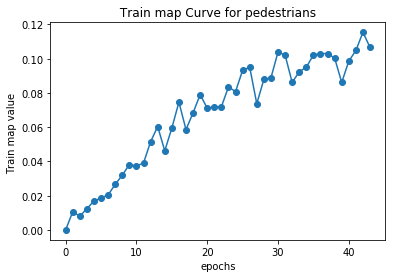

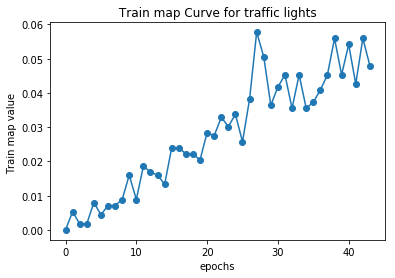

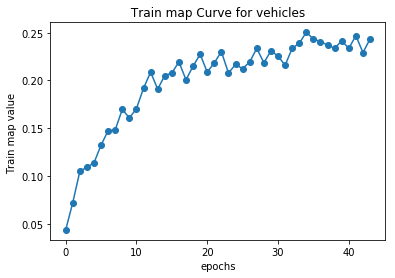

Epoch 44/50
Train Epoch: 44 [0/9000 (0%)]	Loss: 9.746458
train map is : 1.0
Train Epoch: 44 [160/9000 (2%)]	Loss: 6.568806
train map is : 0.9090909090909091
Train Epoch: 44 [320/9000 (4%)]	Loss: 2.657873
train map is : 0.9047619047619048
Train Epoch: 44 [480/9000 (5%)]	Loss: 5.075519
train map is : 0.8387096774193549
Train Epoch: 44 [640/9000 (7%)]	Loss: 5.853750
train map is : 0.8780487804878049
Train Epoch: 44 [800/9000 (9%)]	Loss: 4.700652
train map is : 0.8235294117647058
Train Epoch: 44 [960/9000 (11%)]	Loss: 2.942081
train map is : 0.8524590163934426
Train Epoch: 44 [1120/9000 (12%)]	Loss: 3.806909
train map is : 0.8591549295774648
Train Epoch: 44 [1280/9000 (14%)]	Loss: 2.658849
train map is : 0.8765432098765432
Train Epoch: 44 [1440/9000 (16%)]	Loss: 3.734928
train map is : 0.8571428571428571
Train Epoch: 44 [1600/9000 (18%)]	Loss: 3.895374
train map is : 0.8415841584158416
Train Epoch: 44 [1760/9000 (20%)]	Loss: 6.782928
train map is : 0.8468468468468469
Train Epoch: 44 [1920/

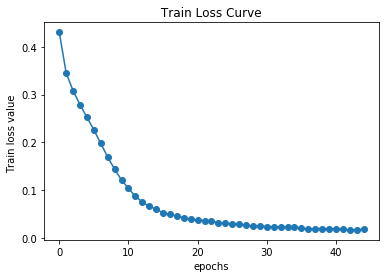

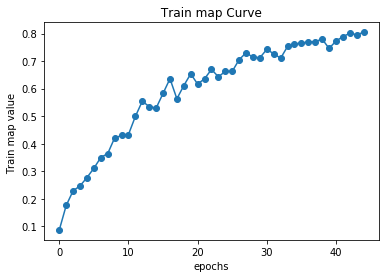

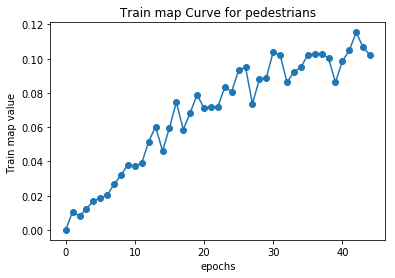

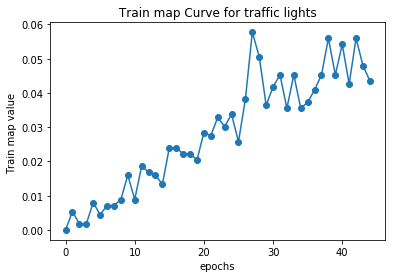

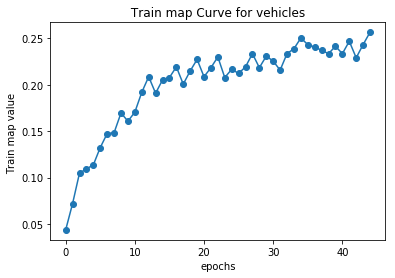

Epoch 45/50
Train Epoch: 45 [0/9000 (0%)]	Loss: 1.933813
train map is : 1.0
Train Epoch: 45 [160/9000 (2%)]	Loss: 6.487175
train map is : 0.9090909090909091
Train Epoch: 45 [320/9000 (4%)]	Loss: 1.929597
train map is : 0.7619047619047619
Train Epoch: 45 [480/9000 (5%)]	Loss: 3.847614
train map is : 0.7419354838709677
Train Epoch: 45 [640/9000 (7%)]	Loss: 2.306622
train map is : 0.7560975609756098
Train Epoch: 45 [800/9000 (9%)]	Loss: 3.521854
train map is : 0.7647058823529411
Train Epoch: 45 [960/9000 (11%)]	Loss: 3.334212
train map is : 0.7868852459016393
Train Epoch: 45 [1120/9000 (12%)]	Loss: 3.437724
train map is : 0.8028169014084507
Train Epoch: 45 [1280/9000 (14%)]	Loss: 2.630415
train map is : 0.8024691358024691
Train Epoch: 45 [1440/9000 (16%)]	Loss: 2.285907
train map is : 0.8241758241758241
Train Epoch: 45 [1600/9000 (18%)]	Loss: 1.777947
train map is : 0.8316831683168316
Train Epoch: 45 [1760/9000 (20%)]	Loss: 4.208424
train map is : 0.8198198198198198
Train Epoch: 45 [1920/

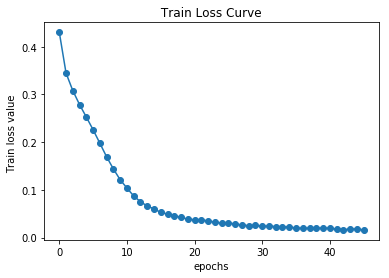

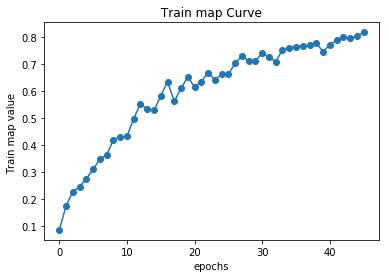

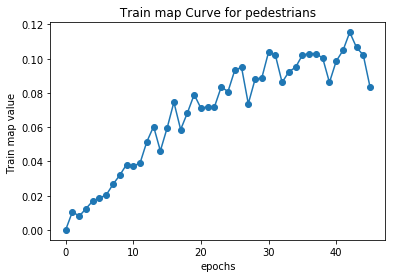

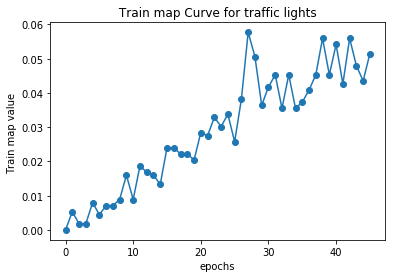

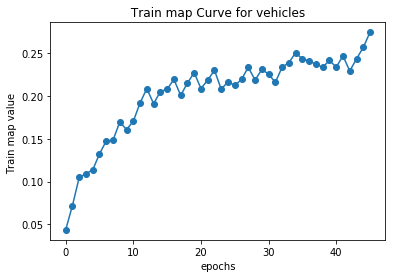

Epoch 46/50
Train Epoch: 46 [0/9000 (0%)]	Loss: 4.635234
train map is : 1.0
Train Epoch: 46 [160/9000 (2%)]	Loss: 3.373545
train map is : 0.9090909090909091
Train Epoch: 46 [320/9000 (4%)]	Loss: 5.023868
train map is : 0.8571428571428571
Train Epoch: 46 [480/9000 (5%)]	Loss: 2.958833
train map is : 0.9032258064516129
Train Epoch: 46 [640/9000 (7%)]	Loss: 2.475047
train map is : 0.9024390243902439
Train Epoch: 46 [800/9000 (9%)]	Loss: 6.752734
train map is : 0.9215686274509803
Train Epoch: 46 [960/9000 (11%)]	Loss: 4.003338
train map is : 0.9016393442622951
Train Epoch: 46 [1120/9000 (12%)]	Loss: 4.366790
train map is : 0.8732394366197183
Train Epoch: 46 [1280/9000 (14%)]	Loss: 3.931396
train map is : 0.8765432098765432
Train Epoch: 46 [1440/9000 (16%)]	Loss: 2.647854
train map is : 0.8681318681318682
Train Epoch: 46 [1600/9000 (18%)]	Loss: 7.825352
train map is : 0.8712871287128713
Train Epoch: 46 [1760/9000 (20%)]	Loss: 3.572596
train map is : 0.8648648648648649
Train Epoch: 46 [1920/

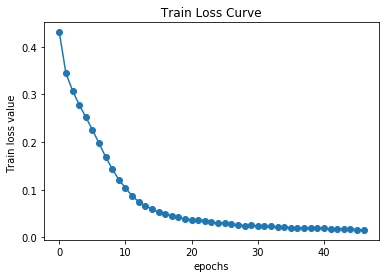

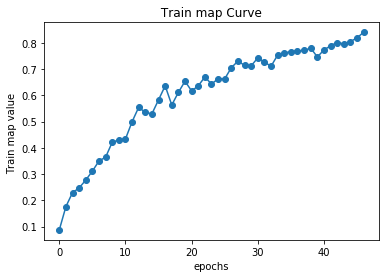

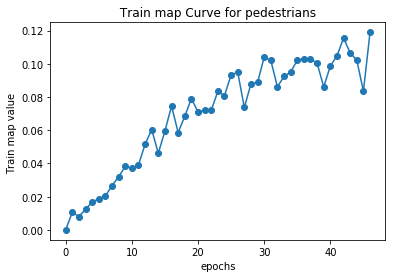

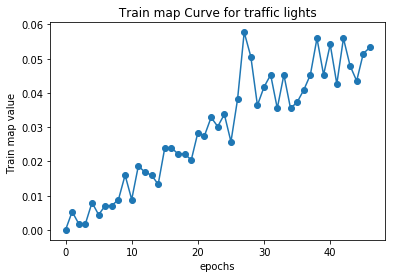

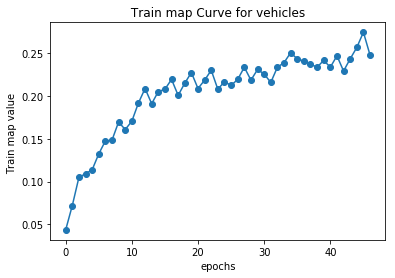

Epoch 47/50
Train Epoch: 47 [0/9000 (0%)]	Loss: 2.204958
train map is : 1.0
Train Epoch: 47 [160/9000 (2%)]	Loss: 4.959322
train map is : 0.9090909090909091
Train Epoch: 47 [320/9000 (4%)]	Loss: 5.190645
train map is : 0.9047619047619048
Train Epoch: 47 [480/9000 (5%)]	Loss: 6.639004
train map is : 0.9032258064516129
Train Epoch: 47 [640/9000 (7%)]	Loss: 3.332476
train map is : 0.8780487804878049
Train Epoch: 47 [800/9000 (9%)]	Loss: 2.396167
train map is : 0.8823529411764706
Train Epoch: 47 [960/9000 (11%)]	Loss: 4.989560
train map is : 0.8852459016393442
Train Epoch: 47 [1120/9000 (12%)]	Loss: 4.417232
train map is : 0.8591549295774648
Train Epoch: 47 [1280/9000 (14%)]	Loss: 6.198423
train map is : 0.8148148148148148
Train Epoch: 47 [1440/9000 (16%)]	Loss: 3.876154
train map is : 0.8131868131868132
Train Epoch: 47 [1600/9000 (18%)]	Loss: 2.667621
train map is : 0.8217821782178217
Train Epoch: 47 [1760/9000 (20%)]	Loss: 2.716264
train map is : 0.8198198198198198
Train Epoch: 47 [1920/

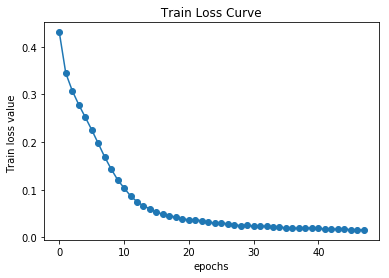

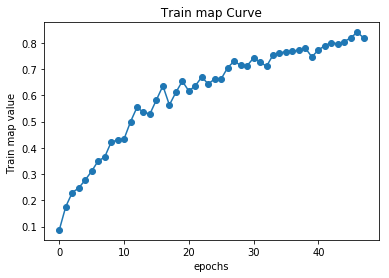

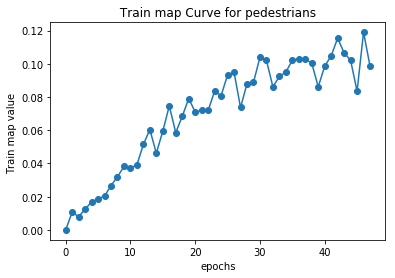

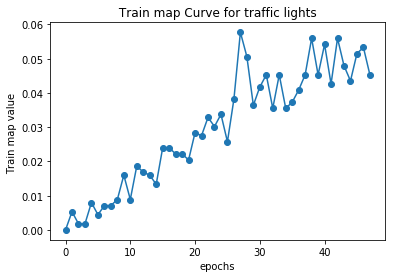

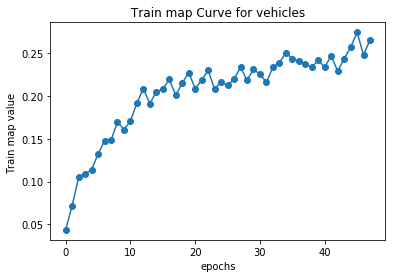

Epoch 48/50
Train Epoch: 48 [0/9000 (0%)]	Loss: 4.504589
train map is : 1.0
Train Epoch: 48 [160/9000 (2%)]	Loss: 1.963559
train map is : 0.8181818181818182
Train Epoch: 48 [320/9000 (4%)]	Loss: 3.393298
train map is : 0.8571428571428571
Train Epoch: 48 [480/9000 (5%)]	Loss: 4.764239
train map is : 0.9032258064516129
Train Epoch: 48 [640/9000 (7%)]	Loss: 2.576644
train map is : 0.926829268292683
Train Epoch: 48 [800/9000 (9%)]	Loss: 2.946079
train map is : 0.9411764705882353
Train Epoch: 48 [960/9000 (11%)]	Loss: 2.927948
train map is : 0.9344262295081968
Train Epoch: 48 [1120/9000 (12%)]	Loss: 3.252108
train map is : 0.9014084507042254
Train Epoch: 48 [1280/9000 (14%)]	Loss: 5.008514
train map is : 0.9135802469135802
Train Epoch: 48 [1440/9000 (16%)]	Loss: 5.423743
train map is : 0.9230769230769231
Train Epoch: 48 [1600/9000 (18%)]	Loss: 5.068197
train map is : 0.9108910891089109
Train Epoch: 48 [1760/9000 (20%)]	Loss: 5.227467
train map is : 0.8918918918918919
Train Epoch: 48 [1920/9

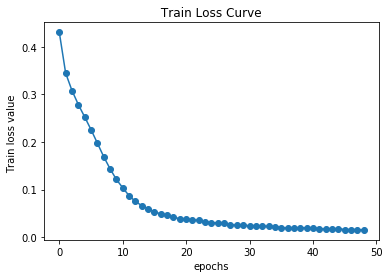

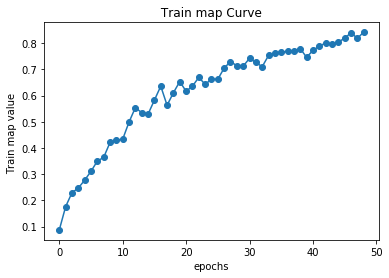

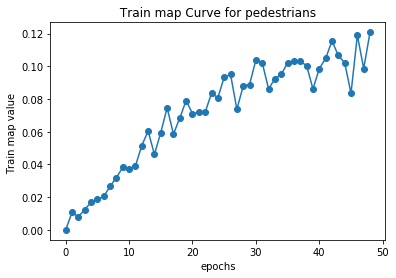

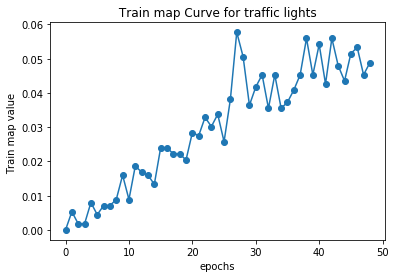

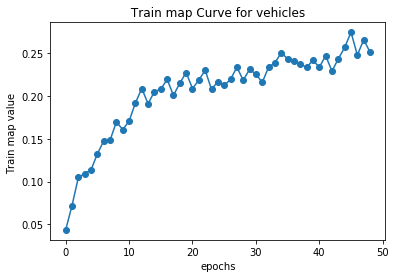

Epoch 49/50
Train Epoch: 49 [0/9000 (0%)]	Loss: 5.952292
train map is : 1.0
Train Epoch: 49 [160/9000 (2%)]	Loss: 3.892227
train map is : 0.8181818181818182
Train Epoch: 49 [320/9000 (4%)]	Loss: 3.940874
train map is : 0.8095238095238095
Train Epoch: 49 [480/9000 (5%)]	Loss: 2.122148
train map is : 0.7741935483870968
Train Epoch: 49 [640/9000 (7%)]	Loss: 2.874321
train map is : 0.8048780487804879
Train Epoch: 49 [800/9000 (9%)]	Loss: 5.695082
train map is : 0.803921568627451
Train Epoch: 49 [960/9000 (11%)]	Loss: 3.507055
train map is : 0.819672131147541
Train Epoch: 49 [1120/9000 (12%)]	Loss: 3.752123
train map is : 0.8169014084507042
Train Epoch: 49 [1280/9000 (14%)]	Loss: 4.040052
train map is : 0.8148148148148148
Train Epoch: 49 [1440/9000 (16%)]	Loss: 2.650531
train map is : 0.8021978021978022
Train Epoch: 49 [1600/9000 (18%)]	Loss: 1.828323
train map is : 0.8217821782178217
Train Epoch: 49 [1760/9000 (20%)]	Loss: 4.829738
train map is : 0.8108108108108109
Train Epoch: 49 [1920/90

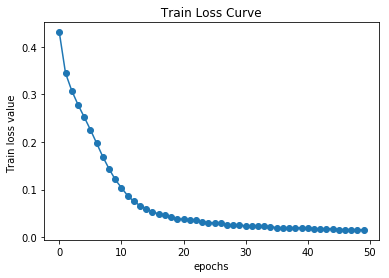

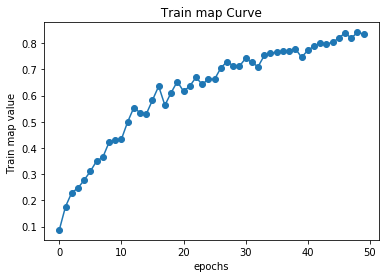

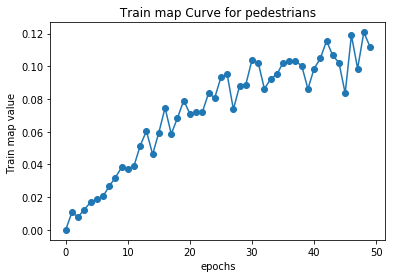

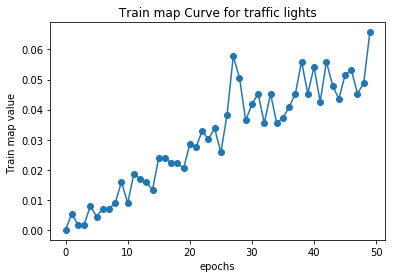

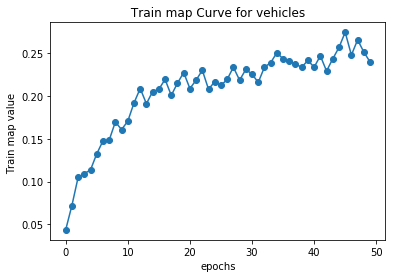

Epoch 50/50


In [0]:
import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
import numpy as np 
import matplotlib.pyplot as plt


net = YOLOish().cuda()

train_loader = torch.utils.data.DataLoader(dataset=HW2TrainDataset(None),batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=HW2TestDataset(None),batch_size = 16, shuffle = True)

optimizer = optim.Adam(net.parameters(), lr = 0.01)


def criterion(ouput,target):
  
  coordinate_loss = 0
  dimension_loss = 0 
  objectness_loss = 0
  background_loss = 0
  object_class_loss = 0
  lambda_coord = 5
  lambda_nobj = 0.5
  
  ouput = ouput.type(torch.DoubleTensor).cuda()
  objectness = (target[:,0]==1.0).type(torch.DoubleTensor).cuda()
  nobjectness = (~(target[:,0]==1.0)).type(torch.DoubleTensor).cuda()
  coordinate_loss = torch.sum(objectness*((target[:,1]-ouput[:,1])**2) + objectness*((target[:,2]-ouput[:,2])**2))
  dimension_loss = torch.sum(objectness*((target[:,3]**(1/2)-ouput[:,3]**(1/2))**2) + objectness*((target[:,4]**(1/2)-ouput[:,4]**(1/2))**2))
  objectness_loss =  torch.sum(objectness*((target[:,0]-ouput[:,0])**2))
  background_loss =  torch.sum((nobjectness)*((target[:,0]-ouput[:,0])**2))
  object_class_loss = torch.sum(objectness*(((target[:,5]-ouput[:,5])**2)+((target[:,6]-ouput[:,6])**2)+((target[:,7]-ouput[:,7])**2)))
  
  loss = lambda_coord * (coordinate_loss + dimension_loss) + objectness_loss + lambda_nobj*background_loss + object_class_loss
  return loss

def iou(output,target,i,j):
  
  axmin = output[1]*16 + 16*j - (output[3]*128)/2
  axmax = output[1]*16 + 16*j + (output[3]*128)/2
  aymin = output[2]*16 + 16*i - (output[4]*128)/2
  aymax = output[2]*16 + 16*i + (output[4]*128)/2
  awidth = output[3]*128
  aheight = output[4]*128
  aarea = awidth*aheight
  
  bxmin = target[1]*16 + 16*j - (target[3]*128)/2
  bxmax = target[1]*16 + 16*j + (target[3]*128)/2
  bymin = target[2]*16 + 16*i - (target[4]*128)/2
  bymax = target[2]*16 + 16*i + (target[4]*128)/2
  bwidth = target[3]*128
  bheight = target[4]*128
  barea = bwidth*bheight

  aibw = max(0,min(axmax,bxmax)-max(axmin,bxmin))
  aibh = max(0,min(aymax,bymax)-max(aymin,bymin))
  aib = aibw*aibh
  aub = aarea + barea - aib 
  iou = aib/aub
  return iou
  

def map(output,target):
  output_check = output.detach().cpu().numpy().copy()
  target_check = target.detach().cpu().numpy().copy()
  total_correct = 0.0
  correct = 0.0
  correct_p = 0.0
  correct_v = 0.0
  correct_t = 0.0
  total_correct_p = 1.0
  total_correct_v = 1.0
  total_correct_t = 1.0
  for b in range(16):
    for i in range(8):
        for j in range(8):
          if target_check[b][0][i][j] == 1:
            total_correct+=1.0
            if target_check[b][5][i][j] == 1:
              total_correct_p +=1
            if target_check[b][6][i][j] == 1:
              total_correct_t +=1
            if target_check[b][7][i][j] == 1:
              total_correct_v +=1
            class1 = output_check[b][5][i][j]
            class2 = output_check[b][6][i][j]
            class3 = output_check[b][7][i][j]
            index = [class1,class2,class3].index(max([class1,class2,class3]))
            classification = False
            iou_val = False
            output_compare = [output_check[b][0][i][j],output_check[b][1][i][j],output_check[b][2][i][j],output_check[b][3][i][j],output_check[b][4][i][j]] 
            target_compare = [target_check[b][0][i][j],target_check[b][1][i][j],target_check[b][2][i][j],target_check[b][3][i][j],target_check[b][4][i][j]] 
            iou_rat = iou(output_compare,target_compare,i,j)
#             print(" iou value is : ", iou_rat)
            if (target[b][5+index][i][j]==1):
#               print("correctly classified")
              classification = True
              if index==0:
                correct_p+=1
              if index==1:
                correct_t+=1
              if index==2:
                correct_v+=1
            if (iou_rat>0.5):
#               print("correctly localized")
              iou_val = True
            if(classification and iou_val):
              correct+=1.0
              return (correct/total_correct),(correct_p/total_correct_p),(correct_t/total_correct_t),(correct_v/total_correct_v)
            return 0.0,0.0,0.0,0.0
  
  

def train(model, train_loader, optimizer, epoch):
    model.train()
    accuracy  = 0.0
    accuracy_p  = 0.0
    accuracy_t  = 0.0
    accuracy_v  = 0.0
    loss_vals  = []
    train_loss = 0
    i = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        i+=1
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
#         loss = 0
        loss = criterion(output, target)
        loss.backward()
        train_loss = train_loss + (loss.item()/16)
        optimizer.step()
        accuracy_o,accuracy_p_o,accuracy_t_o,accuracy_v_o = map(output,target)
        accuracy = accuracy + accuracy_o
        accuracy_p = accuracy_p + accuracy_p_o
        accuracy_t = accuracy_t + accuracy_t_o
        accuracy_v = accuracy_v + accuracy_v_o
        if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss.item()))
          print("train map is :", accuracy/i)
    return train_loss/9000,accuracy/i,accuracy_p/i,accuracy_t/i,accuracy_v/i

def test(model,criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    act_correct = 0
    acc_vals = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
          
            pred = torch.zeros((1,3,8,8)).type(torch.DoubleTensor).cuda()
            for i in range(8):
              for j in range(8):
                if target[0][0][i][j] == 1:
                  class1 = output[0][5][i][j]
                  class2 = output[0][6][i][j]
                  class3 = output[0][7][i][j]
                  index = [class1,class2,class3].index(max([class1,class2,class3]))
                  pred[0][index][i][j] = 1
            correct +=torch.sum(pred*target[:][0][5:])
            act_correct +=torch.sum(target[:][0][5:])
            
    test_loss /= len(test_loader.dataset)
    accuracy = correct.item()/act_correct.item()    
    print("loss is = ", test_loss, "and accuracy is = ", accuracy )
    return test_loss,accuracy
            
                  
                  

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss,correct/len(test_loader.dataset)

  
num_epochs = 50
train_loss_list = []
acc_val_train = []
acc_val_train_p = []
acc_val_train_t = []
acc_val_train_v = []

loss_val_test = []
acc_val_test = []

plt.figure()

for epoch in range(num_epochs):
  loss_vals,acc,acc_p,acc_t,acc_v= train(net, train_loader, optimizer, epoch)
#   break
  train_loss_list.append(loss_vals)
  acc_val_train.append(acc)
  acc_val_train_p.append(acc_p)
  acc_val_train_t.append(acc_t)
  acc_val_train_v.append(acc_v)
  test_loss,acc_vals = test( net,criterion, test_loader)
  loss_val_test.append(test_loss)
  acc_val_test.append(acc_vals)
  f1 = plt.figure(1)
  plt.plot(list(train_loss_list),marker = 'o')
  plt.xlabel("epochs")
  plt.ylabel("Train loss value ")
  plt.title(" Train Loss Curve ")
  f1.show()
  f2 = plt.figure(2)
  plt.plot(list(acc_val_train),marker = 'o')
  plt.xlabel("epochs")
  plt.ylabel("Train map value ")
  plt.title(" Train map Curve ")
  f2.show()
  f3 = plt.figure(3)
  plt.plot(list(acc_val_train_p),marker = 'o')
  plt.xlabel("epochs")
  plt.ylabel("Train map value ")
  plt.title(" Train map Curve for pedestrians ")
  f3.show()
  f4 = plt.figure(4)
  plt.plot(list(acc_val_train_t),marker = 'o')
  plt.xlabel("epochs")
  plt.ylabel("Train map value ")
  plt.title(" Train map Curve for traffic lights ")
  f4.show()
  f5 = plt.figure(5)
  plt.plot(list(acc_val_train_v),marker = 'o')
  plt.xlabel("epochs")
  plt.ylabel("Train map value ")
  plt.title(" Train map Curve for vehicles ")
  f5.show()
  plt.show()
#   raw_input()
  
  print("Epoch %d/%d" % (epoch+1, num_epochs))

# Test your network

Testing the network on Unseen images 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


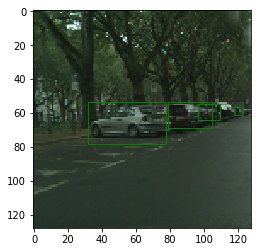

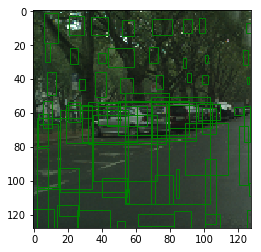

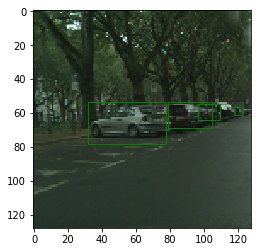

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = net(data)
        loss = criterion(output,target)
        break

# train_dataset = HW2TrainDataset(None)
# image,label = train_dataset.__getitem__(0)
# print(image.shape)

image = data.type(torch.IntTensor).numpy()
image = image[0]
image = np.transpose(image,(1,2,0))
fig,ax = plt.subplots(1)
fig1,ax1 = plt.subplots(1) 
fig1,ax2 = plt.subplots(1)


objectness = (target[:,0]==1.0).type(torch.FloatTensor).cuda()
label = output.cpu().numpy()

label = label[0]


ax1.imshow(image)
for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.0:
      if label[5][i][j]>0.0:
#         print("creting bounding box for a pedestrian")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect1)
      if label[6][i][j]>0.0:
#         print("creting bounding box for a traffic light")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax1.add_patch(rect2)
      if label[7][i][j]>0.0:
#         print("creting bounding box for a car")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax1.add_patch(rect3)


objectness = (label[0]>0.6).astype(int)
label[1] = objectness*label[1]
label[2] = objectness*label[2]
label[3] = objectness*label[3]
label[4] = objectness*label[4]
label[5] = objectness*label[5]
label[6] = objectness*label[6]
label[7] = objectness*label[7]


for i in range(8):
  for j in range(8):
    max_val = max(label[5][i][j],label[6][i][j],label[7][i][j])
    if label[5][i][j] != max_val:
      label[5][i][j] = 0
    if label[6][i][j] != max_val:
      label[6][i][j] = 0
    if label[7][i][j] != max_val:
      label[7][i][j] = 0

ax2.imshow(image)
for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.0:
      if label[5][i][j]>0.0:
#         print("creting bounding box for a pedestrian")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax2.add_patch(rect1)
      if label[6][i][j]>0.0:
#         print("creting bounding box for a traffic light")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax2.add_patch(rect2)
      if label[7][i][j]>0.0:
#         print("creting bounding box for a car")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax2.add_patch(rect3)

        
for c in range(5,8):
  for i in range(8):
    for j in range(8):
      if(label[c][i][j]==0):
        continue
      axmin = label[1][i][j]*16 + 16*j - (label[3][i][j]*128)/2
      axmax = label[1][i][j]*16 + 16*j + (label[3][i][j]*128)/2
      aymin = label[2][i][j]*16 + 16*i - (label[4][i][j]*128)/2
      aymax = label[2][i][j]*16 + 16*i + (label[4][i][j]*128)/2
      awidth = label[3][i][j]*128
      aheight = label[4][i][j]*128
      aarea = awidth*aheight

      for p in range(8):
        for q in range(8):
          if(label[c][p][q]==0):
            continue
          if(p!=i and q!=j):
            bxmin = label[1][p][q]*16 + 16*q - (label[3][p][q]*128)/2
            bxmax = label[1][p][q]*16 + 16*q + (label[3][p][q]*128)/2
            bymin = label[2][p][q]*16 + 16*p - (label[4][p][q]*128)/2
            bymax = label[2][p][q]*16 + 16*p + (label[4][p][q]*128)/2
            bwidth = label[3][p][q]*128
            bheight = label[4][p][q]*128
            barea = bwidth*bheight

            aibw = max(0,min(axmax,bxmax)-max(axmin,bxmin))
            aibh = max(0,min(aymax,bymax)-max(aymin,bymin))
            aib = aibw*aibh
            aub = aarea + barea - aib 
            iou = aib/aub

            if iou > 0.5:
              if label[c][i][j]>label[c][p][q]:
                label[0][p][q] = 0
              elif label[c][i][j]<label[c][p][q]:
                label[0][i][j] = 0
              
            
ax.imshow(image)
for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.6:
      if label[5][i][j]>0.5:
#         print("creting bounding box for a pedestrian")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0.5:
#         print("creting bounding box for a traffic light")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0.5:
#         print("creting bounding box for a car")
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
        
plt.show()
